<div align='right' ><img src='http://www.ed.ac.uk/files/styles/banner_breakpoints_theme_uoe_tv_1x/public/banner/sgpe-banner-wordpress-edweb-resized.jpg?itok=acgIJWdM&timestamp=1454944200' width="1000" height="100" align='left'></div>
<div align='center' ><img src='http://www.sire.ac.uk/images/sirelogol.jpg' width="1200" height="100"></div>

#*Numerical Methods for Economists:* The Ramsey-Cass-Koopmans Model

In the previous lab, we learned how to simulate a deterministic, continuous-time version of the Solow growth model where the savings rate of the economy was taken to be exogenous.  In this lab, we will learn how to solve and simulate a deteministic, continuous time version of the neoclassical optimal growth model, often referred to as the Ramsey-Cass-Koopmans model, where the savings rate is endogenously chosen optimally by a representative household.  

A preview of what we will cover in this lab:

* **Task 1:** Coding the optimal growth model in Python
* **Task 2:** Calibrating the model
* **Task 3:** Analyzing the phase diagram
* **Task 4:** Solving and simulating the model
* **Task 5:** Impulse response functions


In [2]:
# These libaries will be doing the bulk of the heavy lifting!
import numpy as np
import pandas as pd
import sympy as sp
from scipy import linalg

# these models contain all of the code
import ramsey
import pwt

# matplotlib is for graphics, seaborn for nice graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# fix division as prevention from typos
from __future__ import division

%load_ext autoreload
%autoreload 2

In [3]:
# this function will allow for pretty LaTex printing within the IPython notebook
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

# Task 1: Coding the optimal growth model in Python

In this task you will learn how to program a continuous time version of the optimal growth model in Python. Before we starting writing code, we should stop and think about the "primitives" (i.e., basic bulding blocks) of an optimal growth model. 

## Coding $f(k)$ and $f'(k)$:
In the previous lab we began coding up the Solow model by writing a Python function representing the intensive form of a [Cobb-Douglas](http://en.wikipedia.org/wiki/Cobb%E2%80%93Douglas_production_function) production function. In this lab we will assume that $f$ has the more general constant elasticity of substitution (CES) form

$$f(k(t)) = \bigg[\alpha k(t)^\gamma + (1 - \alpha)\bigg]^{\frac{1}{\gamma}} \tag{1.1a}$$

where $0 < \alpha < 1$ and $-\infty < \gamma < 1$. The parameter $\gamma = \frac{\sigma - 1}{\sigma}$ where $\sigma$ is the elasticity of substitution between capital and effective labor. Recall that the CES production technology nests the Cobb-Douglas function

$$ f(k(t)) = k(t)^{\alpha} \tag{1.1b}$$

as a special case when $\sigma=1$. 

### Exercise 1:

Use the information above to complete the [Python function](http://www.greenteapress.com/thinkpython/html/thinkpython004.html) `ces_output` defined below. 

In [ ]:
def ces_output(t, k, params):
    """
    Constant elasticity of substitution (CES) production function.

    Arguments:

        t:      (array) Time.
        k:      (array) Capital (per person/effective person).
        params: (dict) Dictionary of parameter values.
       
    Returns:

        y: (array-like) Output (per person/ effective person)

    """
    # extract params
    alpha = params['alpha']
    sigma = params['sigma']
    gamma = (sigma - 1) / sigma
    
    # nest Cobb-Douglas as special case
    if gamma == 0:
        y = # INSERT CODE HERE!!
    else:
        y = # INSERT CODE HERE!!
    
    return y

In [4]:
# my solution is as follows
def ces_output(t, k, params):
    """
    Constant elasticity of substitution (CES) production function.

    Arguments:

        t:      (array) Time.
        k:      (array) Capital (per person/effective person).
        params: (dict) Dictionary of parameter values.
       
    Returns:

        y: (array-like) Output (per person/ effective person)

    """
    # extract params
    alpha = params['alpha']
    sigma = params['sigma']
    gamma = (sigma - 1) / sigma
    
    # nest Cobb-Douglas as special case
    if gamma == 0:
        y = k**alpha
    else:
        y = (alpha * k**gamma + (1 - alpha))**(1 / gamma)
    
    return y

We will also need to code a function defining the marginal product of capital per effective person.  From your homework assignment, you should recall that 

$$ f'(k) = \alpha k(t)^{\gamma-1}\bigg[\alpha k(t)^{\gamma} + (1-\alpha)\bigg]^{\frac{1}{\gamma} - 1} \tag{1.2a}$$

for $\sigma \neq 1$ and 

$$f'(k) = \alpha k(t)^{\alpha-1} \tag{1.2b}$$

for the Cobb-Douglas special case when $\sigma = 1$. 

### Exercise 2:

Use the information above to complete the [Python function](http://www.greenteapress.com/thinkpython/html/thinkpython004.html) `marginal_product_capital` defined below. 

In [ ]:
def marginal_product_capital(t, k, params):
    """
    Marginal product of capital for CES production function.

    Arguments:

        t:      (array-like) Time.
        k:      (array-like) Capital (per person/effective person).
        params: (dict) Dictionary of parameter values.
       
    Returns:

        mpk: (array-like) Derivative of output with respect to capital, k.

    """
    # extract params
    alpha = params['alpha']
    sigma = params['sigma']
    gamma = (sigma - 1) / sigma
    
    # nest Cobb-Douglas as special case
    if gamma == 0:
        mpk = # INSERT CODE HERE!!
    else:
        mpk = # INSERT CODE HERE!!
    
    return mpk


In [5]:
# my solution!
def marginal_product_capital(t, k, params):
    """
    Marginal product of capital for CES production function.

    Arguments:

        t:      (array-like) Time.
        k:      (array-like) Capital (per person/effective person).
        params: (dict) Dictionary of parameter values.
       
    Returns:

        mpk: (array-like) Derivative of output with respect to capital, k.

    """
    # extract params
    alpha = params['alpha']
    sigma = params['sigma']
    gamma = (sigma - 1) / sigma
    
    # nest Cobb-Douglas as special case
    if gamma == 0:
        mpk = alpha * k**(alpha - 1)
    else:
        mpk = alpha * k**(gamma - 1) * (alpha * k**gamma + (1 - alpha))**((1 / gamma) - 1)
    
    return mpk

## Coding the equilibrium system of ODEs:

From the lecture you should recall that the equilibrium of the continuous-time, optimal growth model is described by the following two-dimensional system of ordinary differential equations (ODEs).

\begin{align}
 	\dot{k} =& f(k(t)) - (n+g+\delta)k(t) - c(t),\ k(0) = k_0 \tag{1.3}\\
	\dot{c} =& \left[\frac{f'(k(t)) - \delta - \rho - \theta g}{\theta}\right]c(t),\ 0 < \lim_{t\rightarrow\infty} |c(t)| < \infty \tag{1.4}
\end{align}

Equation 1.3 is the equation of motion for capital per effective person and equation 1.4 is the consumption Euler equation. 

### Exercise 3:

Use the information above to complete the [Python functions](http://www.greenteapress.com/thinkpython/html/thinkpython004.html) `equation_motion_capital` and `consumption_euler_equation` defined below. 

In [ ]:
def equation_motion_capital(t, vec, params):
    """
    Equation of motion for capital (per person/ effective person).

    Arguments:

        t:      (array-like) Time.
        vec:    (array-like) Vector of endogenous variables [k, c] where k is 
                capital (per person/effective person) and c is consumption 
                (per person/effective person).
        params: (dict) Dictionary of parameter values.
       
    Returns:

        k_dot: (array-like) Rate of change in the stock of captial 
               (per person/effective person).

    """
    # extract params
    n     = params['n']
    g     = params['g']
    delta = params['delta']
    
    # unpack the vector of endogenous variables
    k, c = vec
    
    # formula for the equation of motion for capital 
    k_dot = # INSERT CODE HERE!!
    
    return k_dot

def consumption_euler_equation(t, vec, params):
    """
    Equation of motion for consumption (per person/ effective person).

    Arguments:

        t:      (array-like) Time.
        vec:    (array-like) Vector of endogenous variables [k, c] where k is 
                capital (per person/effective person) and c is consumption 
                (per person/effective person).
        params: (dict) Dictionary of parameter values.
       
    Returns:

        c_dot: (array-like) Rate of change in consumption (per person/effective 
               person).

    """
    # extract params
    g     = params['g']
    delta = params['delta']
    rho   = params['rho']
    theta = params['theta']
    
    # unpack the vector of endogenous variables
    k, c = vec
    
    # marginal product of capital
    mpk = # INSERT CODE HERE!!

    # formula for the equation of motion for consumption
    c_dot = # INSERT CODE HERE!!
    
    return c_dot

In [6]:
# my solutions!
def equation_motion_capital(t, vec, params):
    """
    Equation of motion for capital (per person/ effective person).

    Arguments:

        t:      (array-like) Time.
        vec:    (array-like) Vector of endogenous variables [k, c] where k is 
                capital (per person/effective person) and c is consumption 
                (per person/effective person).
        params: (dict) Dictionary of parameter values.
       
    Returns:

        k_dot: (array-like) Rate of change in the stock of captial 
               (per person/effective person).

    """
    # extract params
    n     = params['n']
    g     = params['g']
    delta = params['delta']
    
    # unpack the vector of endogenous variables
    k, c = vec
    
    # formula for the equation of motion for capital 
    k_dot = ces_output(t, k, params) - (n + g + delta) * k - c
    
    return k_dot

def consumption_euler_equation(t, vec, params):
    """
    Equation of motion for consumption (per person/ effective person).

    Arguments:

        t:      (array-like) Time.
        vec:    (array-like) Vector of endogenous variables [k, c] where k is 
                capital (per person/effective person) and c is consumption 
                (per person/effective person).
        params: (dict) Dictionary of parameter values.
       
    Returns:

        c_dot: (array-like) Rate of change in consumption (per person/effective 
               person).

    """
    # extract params
    g     = params['g']
    delta = params['delta']
    rho   = params['rho']
    theta = params['theta']
    
    # unpack the vector of endogenous variables
    k, c = vec
    
    # marginal product of capital
    mpk = marginal_product_capital(t, k, params)

    # formula for the equation of motion for consumption
    c_dot = ((mpk - delta - rho - theta * g) / theta) * c
    
    return c_dot

## Coding the instantaneous utility function, $u(c)$:

Recall that the consumption Euler equation as defined above assumes that the representative household hold has constant relative risk aversion (CRRA) utility.

$$u(c) = \frac{c^{1 - \theta} - 1}{1 - \theta} \tag{1.5a}$$

where utility is a function of consumption per effective person, $c$. The parameter,  $0 \lt \theta$, plays a dual role:

* $\theta$ is the agent's coefficient of relative risk aversion
* $\frac{1}{\theta}$ is the agent's elasticity of inter-temporal substitution

Things to remember about this utility function:

When $0 \lt \theta$ but "close" to zero, consumer has almost linear (i.e., risk neutral) utility. As $\theta$ increases, households becomes more risk averse (i.e., the curvature of the utility function increases!). Note that this increase in curvature becomes most apparent in the behavior of the utility function for levels of consumption less than 1. As $\theta$ increase the "penalty" for consuming less than 1 unit becomes increasingly severe!

Why is there a '-1' in the numerator come from? It has the effect of making total utility positive or negative depending on whether $c$ is greater than or less than one. Also 

$$\lim_{\theta \rightarrow 1}\ \frac{c^{1 - \theta} - 1}{1 - \theta}\ =\ \ln\ c. \tag{1.5b}$$

It is also **not** necessary! Leaving off the '-1' will still yield CRRA preferences.

In [7]:
def crra_utility(c, params):
    """
    The optimal growth model assumes that the representative individual has CRRA utility.      
    utility. Individual utility is a function of consumption per effective person, c. The 
    parameter, 0 < theta, plays a dual role: 
        
        1) theta is the agent's coefficient of relative risk aversion
        2) 1 / theta is the agent's elasticity of inter-temporal substitution
    
    N.B.: If theta = 1, then CRRA utility is equivalent to log utility! 
    
    Arguments:
    
        c:      (array) Consumption per effective person
        
        params: (dict) Dictionary of model parameters.
        
    Returns: 
    
        utility: (array) An array of values respresenting utility from consumption per 
                 effective worker.
        
    """
    # extract the params
    theta = params['theta']
    
    if theta == 1:
        utility = np.log(c)
    else:
        utility = (c**(1 - theta) - 1) / (1 - theta)
    
    return utility

Let's plot this utility function for different values of the elasticity of intertemporal substitution...

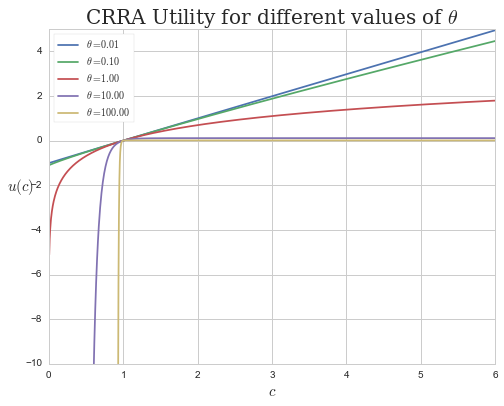

In [8]:
# Create a grid of points for plotting
gridmax, gridsize = 6, 1000
grid = np.linspace(0, gridmax, gridsize)

# Create a new figure
plt.figure(figsize=(8,6))

# create an array of some values for theta
theta_values = np.logspace(-2, 2, 5)

# Plot utility for varying values of theta
for theta in theta_values:
    params = {'theta':theta}
    plt.plot(grid, crra_utility(grid, params), '-', label=r'$\theta=%.2f$' %theta)

# Don't forget to label your axes!
plt.xlabel('$c$', fontsize=15, family='serif')
plt.ylabel('$u(c)$', rotation='horizontal', fontsize=15, family='serif')
plt.axis([0, 6, -10, 5])

# Add a title to the plot
plt.title(r'CRRA Utility for different values of $\theta$', fontsize=20, family='serif')

# Add a legend
plt.legend(loc=2, frameon=True)

# save and display figure!
#plt.savefig('graphics/CRRA-utility.png')
plt.show()

### Coding the Jacobian matrix:
The next piece of the model that we need to construct is the [Jacobian](http://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) matrix of partial derivatives. 

$$ 
\mathcal{J} =
\begin{bmatrix}
\frac{\partial \dot{k}}{\partial k} & \frac{\partial \dot{k}}{\partial c}\\
\frac{\partial \dot{c}}{\partial k} & \frac{\partial \dot{c}}{\partial c}
\end{bmatrix} =
\begin{bmatrix}
f'(k) - (n + g + \delta) & -1\\
\frac{1}{\theta}f''(k) & \frac{f'(k) - \delta - \rho - \theta g}{\theta}
\end{bmatrix} 
\tag{1.5}
$$

The Jacobian matrix plays several important roles in the optimal growth model (and many other economic models!):

1. We can use $\mathcal{J}$ to construct a linear approximation of the full non-linear model via a first-order Taylor expansion around the model's long-run steady-state.
2. We can use the [eigenvalues and eigenvectors](http://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of $\mathcal{J}$ to assess the model's stability properties.
3. $\mathcal{J}$ is also an important input into finite-difference methods for solving boundary value problems (BVPs).  

Although the above matrix of partial derivatives looks fairly straightforward to compute by hand, you may recall from your homework that deriving an analytic expression for $f''$ with CES production is tedious and error prone. In general, a much better strategy is to get the computer to take complicated and error-prone derivatives for you! There are three general approaches that one can use in order to get a computer to take derivatives: [numeric differentiation](http://en.wikipedia.org/wiki/Numerical_differentiation), [symbolic differentiation](http://en.wikipedia.org/wiki/Symbolic_differentiation), or [automatic differentiation](http://en.wikipedia.org/wiki/Automatic_differentiation).  

While numerical differentiation is often very fast, routines that are simple to implement may fail to achieve a high level of accuracy.  Automatic differentiation is the gold-standard but open-source libraries implmenting the techniques are rare (although there are several such libraries currently under development in Python). We will take a middle of the road approach and use symbolic differentiation via [SymPy](http://sympy.org/en/index.html) to compute the model's Jacobian.

In [8]:
# declare symbolic variables
c, k = sp.symbols('c,k')

# declare symbolic parameters
n, g, alpha, delta, rho, sigma, theta = sp.symbols('n,g,alpha,delta,rho,sigma,theta')

We always want to re-use code whenever possible. We have already coded functions for output, marginal product of capital, the equation of motion for capital, and the consumption Euler equation. By being slightly clever, we can use Sympy to differentiate our existing functions!

In [9]:
# create a dictionary of symbolic parameters (recall that params is an input to our functions)
symbolic_params = {'n':n, 'g':g, 'alpha':alpha, 'delta':delta, 'rho':rho, 
                   'sigma':sigma, 'theta':theta}

# wrap the model equations so that they are functions of k and c only!
k_dot = lambda k, c: equation_motion_capital(0, [k, c], symbolic_params)
c_dot = lambda k, c: consumption_euler_equation(0, [k, c], symbolic_params)

In [10]:
# create a SymPy matrix containing the wrapped functions
F     = sp.Matrix([k_dot(k, c), c_dot(k, c)])

# now compute the Jacobian is trivial!
symbolic_jacobian  = F.jacobian([k, c])

In [11]:
# try to simplify as much as possible
symbolic_jacobian.simplify()

# display the symbolic jacobian for the general CES case
print symbolic_jacobian

Matrix([[(alpha*k**((sigma - 1)/sigma)*(alpha*k**((sigma - 1)/sigma) - alpha + 1)**(sigma/(sigma - 1)) - k*(delta + g + n)*(alpha*k**((sigma - 1)/sigma) - alpha + 1))/(k*(alpha*k**((sigma - 1)/sigma) - alpha + 1)), -1], [alpha*c*(k**(-1/sigma)*(alpha*k - alpha*k**(1/sigma) + k**(1/sigma)))**(1/(sigma - 1))*(alpha - 1)/(k*sigma*theta*(alpha*k - alpha*k**(1/sigma) + k**(1/sigma))), alpha*k**(-1/sigma)*(alpha*k*k**(-1/sigma) - alpha + 1)**(1/(sigma - 1))/theta - delta/theta - g - rho/theta]])


In order to differentiate the Cobb-Douglas special case, we need to re-wrap the model equations with a new dictionary of parameters.

In [12]:
# set sigma = 1.0 in order to specify the Cobb-Douglas special case
symbolic_params = {'n':n, 'g':g, 'alpha':alpha, 'delta':delta, 'rho':rho, 
                   'sigma':1.0, 'theta':theta}

k_dot = lambda k, c: equation_motion_capital(0, [k, c], symbolic_params)
c_dot = lambda k, c: consumption_euler_equation(0, [k, c], symbolic_params)
F     = sp.Matrix([k_dot(k, c), c_dot(k, c)])

In [13]:
# now computing the Jacobian 
symbolic_jacobian  = F.jacobian([k, c])

# try to simplify as much as possible
symbolic_jacobian.simplify()

# display the symbolic jacobian for the Cobb-Douglas case
symbolic_jacobian

Matrix([
[        alpha*k**alpha/k - delta - g - n,                                                   -1],
[alpha*c*k**(alpha - 2)*(alpha - 1)/theta, (alpha*k**(alpha - 1) - delta - g*theta - rho)/theta]])

We can actually combine all of the above into a single Python function as follows...

In [14]:
def ramsey_jacobian(t, vec, params):
    """
    The Jacobian for the optimal growth model is computed using symbolic 
    differentiation and then evaluated numerically.

    Arguments:

        t:      (array-like) Time.
        vec:    (array-like) Vector of endogenous variables [k, c] where k is 
                capital (per person/effective person) and c is consumption 
                (per person/effective person).
        params: (dict) Dictionary of parameter values.
       
    Returns:

       jac: (array-like) Jacobian matrix of partial derivatives.

    """
    # declare two symbolic variables
    k, c = sp.symbols('k,c')
    
    # represent the system of equations as a SymPy matrix
    k_dot = lambda k, c: equation_motion_capital(t, [k, c], params)
    c_dot = lambda k, c: consumption_euler_equation(t, [k, c], params)
    F     = sp.Matrix([k_dot(k, c), c_dot(k, c)])

    # now computing the Jacobian is trivial!
    symbolic_jacobian  = F.jacobian([k, c])
        
    # lambdify the function in order to evaluate it numerically
    numeric_jacobian   = sp.lambdify(args=[k, c], expr=symbolic_jacobian, modules='numpy') 
    
    # output num_jac evaluated at vec
    evaluated_jacobian = np.array(numeric_jacobian(vec[0], vec[1]))
    
    return evaluated_jacobian

### Coding the steady state values of $k$ and $c$
Because the Ramsey Model is still relatively simply, we can write down an analytic expressions for the steady state value of capital per effective person and consumption per effective person in terms of the structural parameters of the model. 

In general, the steady state value for capital per effective person is the value of $k$ that solves

$$ f'(k) = \delta + \rho + \theta g. \tag{1.6}$$

For the CES case you should be able to show that 

$$k^* = (1 - \alpha)^{\frac{1}{\gamma}}\Bigg[\left(\frac{\alpha}{\delta + \rho + \theta g}\right)^{\frac{\gamma}{\gamma - 1}} - \left(\frac{\alpha}{1 - \alpha}\right)\Bigg]^{-\frac{1}{\gamma}} \tag{1.7a}$$

when $\sigma \ne 1$, and

$$ k^* = \left(\frac{\alpha}{\delta+\rho+\theta g}\right)^{\frac{1}{1-\alpha}} \tag{1.7b}$$

when $\sigma = 1$. Once the steady state value for capital per effective person is known the steady state value of consumption per effective person can be computed using the equation of motion for capital per effective person.

$$ c^* = f(k^*) - (n + g + \delta)k^* \tag{1.8}$$

Now we need to code these expressions as Python functions...

In [15]:
def analytic_k_star(params): 
    """Steady-state level of capital (per person/effective person)."""
    # extract params
    n     = params['n']
    g     = params['g']
    alpha = params['alpha']
    delta = params['delta']
    rho   = params['rho']
    theta = params['theta']
    sigma = params['sigma']
    gamma = (sigma - 1) / sigma
    
    # nest Cobb-Douglas as special case
    if gamma == 0:
        k_star = (alpha / (delta + rho + theta * g))**(1 / (1 - alpha))
    else:
        k_star = (1 - alpha)**(1 / gamma) * ((alpha / (delta + rho + theta * g))**(gamma / (gamma - 1)) - alpha)**(-1 / gamma)
    
    return k_star

def analytic_c_star(params): 
    """Steady-state level of consumption (per person/effective person)."""
    # extract params
    n     = params['n']
    g     = params['g']
    delta = params['delta']
    
    # compute k_star
    k_star = analytic_k_star(params)
    
    # compute c_star
    c_star = ces_output(0, k_star, params) - (n + g + delta) * k_star
    
    return c_star

### Choosing baseline parameters:
Finally, to complete the description of the model, we need to provide some "reasonable" values for the model parameters in the form of a [Python dictionary](http://www.greenteapress.com/thinkpython/html/thinkpython012.html).

In [16]:
# start by defining a dictionary of parameter values
baseline_params = {'alpha':0.33, 'n':0.025, 'g':0.025, 'rho':0.04, 'theta':2.5, 
                   'delta':0.1, 'sigma':1.0, 'A0':1.0, 'L0':1.0}

### Creating an instance of the `ramsey.Model` class:
Now we are ready to create an instance of the `ramsey.Model` class representing the optimal growth model...

In [17]:
# we create an instance of the optimgal growth model as follows...
model = ramsey.Model(output=ces_output,                
                     mpk=marginal_product_capital, 
                     k_dot=equation_motion_capital, 
                     c_dot=consumption_euler_equation,
                     utility=crra_utility,
                     jacobian=ramsey_jacobian, 
                     params=baseline_params)

### Adding the steady state expressions to the model:

Now we add the steady state functions to the model using by passing a dictionary containing the steady state expressions to the `set_functions` method of the model's `steady_state` attribute.

In [18]:
# create a dictionary containing the steady state expressions
steady_state_funcs = {'k_star':analytic_k_star, 'c_star':analytic_c_star}

# pass it as an arg to the set_functions method
model.steady_state.set_functions(func_dict=steady_state_funcs)

# compute the steady state values!
model.steady_state.set_values()

In [19]:
# display the values as follows
model.steady_state.values

{'c_star': 0.9610104414884609, 'k_star': 2.072767618896681}

# Task 2: Calibration:

In this task I am going to walk you through a simple strategy for calibrating an optimal growth model with CES production using data from the [Penn World Tables (PWT)](http://www.rug.nl/research/ggdc/data/penn-world-table).

## Labor force growth rate, $n$:
To obtain a measure of the labor force growth rate for country $i$, I regress the logarithm of total employed persons, $\verb|emp|$, in country $i$ from the PWT on a constant and a linear time trend.

$$ \ln\ \verb|emp|_i = \beta_0 + \beta_1 \verb|t| + \epsilon_i \tag{2.1}$$

The estimated coefficient $\beta_1$ is then used as my estimate for the $n$. To estimate the initial number of employed persons, $L_0$, I use $e^{\beta_0}$ as the estimate for $L_0$.

## Capital depreciation rate, $\delta$: 
The PWT provides estimated depreciation rates that vary across both time and countries. As an estimate for the rate of capital depreciation for country $i$ I use the time-average of $\verb|delta_k|_{it}$ as provided by the PWT. 

## Elasticity of substitution between capital and effective labor, $\sigma$, and $\alpha$: 
Setting `sigma = 1.0` will calibrate a model with Cobb-Douglas production. In which case $\alpha$ is estimated using data on a country's capital share. Capital's share for country $i$ in year $t$, $\alpha_{it}$ is computed as $\alpha_{it} = 1 - \verb|labsh|_{it}$, where $\verb|labsh|_{it}$ is the labor share of output/income for country $i$ in year $t$ provided by the PWT. I then use the time-average of $\alpha_{it}$ as the estimate of capital's share for country $i$.

If `sigma != 1.0` then both $\sigma$ and $\alpha$ are jointly estimated using non-linear least squares to solve the following optimization problem.

$$\min_{\sigma, \alpha}\ \sum_{t=1}^{T}\left[\ln Y_{i,t} - \left(\frac{\sigma}{\sigma - 1}\right)\ln\bigg(\alpha K_{i,t}^{\frac{\sigma-1}{\sigma}} + (1 - \alpha)(A_{i,t}L_{i,t})^{\frac{\sigma-1}{\sigma}}\bigg)\right]. \tag{2.2}$$

Estimating the parameters of a CES production function is far from trivial:

1. Objective function has lots of local minima (which makes finding the global minimum hard!).
2. Objective function has a discontinuity at $\sigma=1.0$.
3. Estimation results may be sensitive to initial guess.

The estimation procedure...

## Growth rate of technology, $g$:
To obtain a measure of the growth rate of technology for country $i$, I first adjust the total factor productivity measure reported by the PWT, $\verb|rtfpna|$ (which excludes the human capital contribution to TFP), and then regress the logarithm of this adjusted measure of TFP, $\verb|atfpna|$, for country $i$ on a constant and a linear time trend.

$$\ln\ \verb|atfpna|_i = \beta_0 + \beta_1 \verb|t| + \epsilon_i \tag{2.3}$$

The estimated coefficient $\beta_1$ is then used as my estimate for the $g$. To estimate the initial level of technology, $A_0$, I use $e^{\beta_0}$ as the estimate for $A_0$.

## Elasticity of intertemporal substitution, $\frac{1}{\theta}$:
The inverse elasticity of intertemporal substitution is calibrated in so that the model's balanced growth path capital-output ratio matches the average capital-output ratio observed in the data. Put another way, I choose $\theta$ to solve:

$$ \frac{k^*(\alpha, \delta, \rho, \sigma, \theta, g)}{y^*(\alpha, \delta, \rho, \sigma, \theta, g)} - \frac{1}{T}\sum_{t=1}^{T} \frac{K_{i,t}}{Y_{i,t}} = 0 \tag{2.4}$$

## Discount rate, $\rho$: 
The discount rate is a free parameter and must be specified by the user.  The calibrated value of $\theta$ may be sensitive to the choice of $\rho$.

All of this is being done "behind the scenes".  All you need to in order to calibrate the model is pick an [ISO 3 country code](http://en.wikipedia.org/wiki/ISO_3166-1_alpha-3)! Here is an example of the syntax for calibrating an optimal growth model to UK data for the years 1950-2011 (i.e., the entire sample).

    ramsey.calibrate_ces(model=model, iso3_code='GBR', bounds=[1950, 2011], sigma0=0.5, alpha0=0.5, theta0=1.5, rho=0.04)
    
The keyword arguments are defined as follows: 

* `model` is an instance `ramsey.Model` class; 
* `iso3_code` is a valid ISO 3 country code; 
* `bounds` is a list containing the start and end years for the subset of data you wish to use in the calibration; 
* `sigma0` is the initial guess of the optimal value of $\sigma$ (setting `sigma=1.0` will calibrate a model with Cobb-Douglas production); 
* `alpha0` is the initial guess for $\alpha$ (value is ignored if `sigma=1.0`); 
* `theta0` is the initial guess of the "true" value of $\theta$;
* `rho` is the user specifed value for the discount rate.    

In [20]:
# always check the docstring!
ramsey.calibrate_ces?

In [130]:
# calibrate the model to the UK using only data from 1950-2011
ramsey.calibrate_ces(model, iso3_code='GBR', bounds=[1950, 2011], sigma0=0.5, alpha0=0.5, theta0=2.5, rho=0.04)

Total sum of squares: 1372.10637276
Sucessful estimation of sigma and alpha: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
Calibration of theta successful! The solution converged.


ramsey.py:1550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  H**(gamma * (1 - alpha))) - alpha) / (1 - alpha))**(1 / gamma))


In [131]:
# disply the  calibrated parameters
print model.params

{'rho': 0.04, 'g': 0.022736132470636487, 'n': 0.003649116832251627, 'A0': 91.980293558984243, 'L0': 22.668653166436549, 'delta': 0.041320666670799255, 'alpha': 0.5, 'sigma': 0.5, 'theta': 0.88620189397459292}


In [132]:
# display the steady state values
print model.steady_state.values

{'k_star': 3.4396353541410534, 'c_star': 1.3166288898985368}


# Task 3: Analyzing the phase diagram

From the lectures you should recall that when the current level of capital per effectiver worker is less than its long-run steady state value, then 

$$f'(k) > \delta + \rho + \theta g$$

and consumption per effective worker is rising. Similarly, when the current level of capital per effectiver worker is greater than its long-run steady state value, then

$$f'(k) < \delta + \rho + \theta g$$

and consumption per effective worker is falling. The locus of points for which consumption per effective worker is constant (i.e., the set of points for which $\dot{c}=0$) is called the $\dot{c}=0$ locus.


 that the phase diagram for the optimal growth model combines the locus of points for which consumption per effective worker is constant (i.e., the set of points for which $\dot{c}=0$) with the locus of points for which capital per effective worker is constant (i.e., the set of points for which $\dot{k}=0$).



The syntax for plotting a basic phase diagram uses the `plot_phase_diagram` method of the `Model` class as follows:

    model.plot_phase_diagram(gridmax=50, N=1000, arrows = True)
    
the `gridmax` argument specifies the maximum value of the grid of values for capital per effective worker to include in the plot, `N` is the number of grid points to include in the plot, `arrows` specifies whether you wish to include directional arrows in the plot.  All of this information (and much more!) is contained in the docstring for the `plot_phase_diagram` method.

In [26]:
# always check the docstring of a function before using it!
model.plot_phase_diagram?

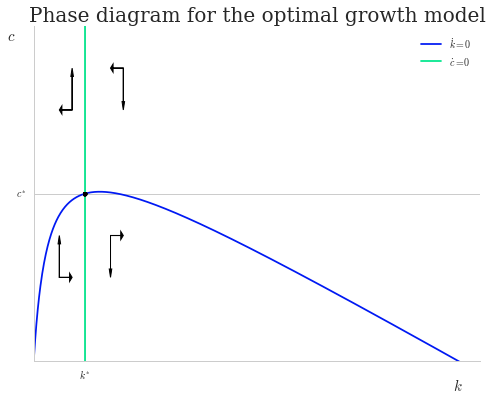

In [133]:
# generate a simple phase diagram plot
plt.figure(figsize=(8,6))

model.plot_phase_diagram(gridmax=30, N=1000, arrows=True)

plt.show()

## Exploring parameter shocks

The syntax for plotting the response of the phase diagram to shocks to the various exogenous parameters of the model is as follows:

    model.plot_phase_diagram(gridmax=100, N=1000, arrows = True, param='delta', shock=0.9, reset=True)
    
The `gridmax`, `N`, and `arrows` arguments are the as above. The `param` argument is the model parameter that you wish to shock, `shock` specifies the magnitude of the *multiplicative* shock that you wish to apply to the parameter, and `reset` specifies whether you wish to reset the model parameters to their pre-shock values.

Thw next cell contains demonstrates how to plot the result of a 50% decrease in the growth rate of technology, $g$.

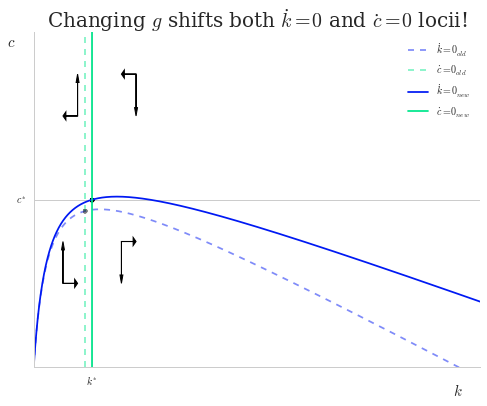

In [135]:
# suppose there is a 50% negative shock to g
plt.figure(figsize=(8,6))
model.plot_phase_diagram(gridmax=30, N=1000, arrows=True, param='g', shock=0.05, reset=True)
plt.show()

In [29]:
model.plot_phase_diagram?

Recall that the location of the $\dot{c}=0$ locus is determined by the steady state value of $k$ which solves

$$f'(k^*) = \delta + \rho + \theta g.$$

Differentiating the above expression with respect to $g$ yields

$$f''(k^*)\frac{\partial k^*}{\partial g} = \theta \implies \frac{\partial k^*}{\partial g} = \frac{\theta}{f''(k^*)} < 0$$

is negative because $f''(k) < 0$ for all $k$. Therefore a fall in $g$ actually increase $k^*$ and thus shifts the $\dot{c}=0$ locus to the right. To see why the $\dot{k}=0$ locus shifts recall that the $\dot{k}=0$ locus is the set of values for $c$ which lead to actual investment equaling break even investment.

$$ 0 = f(k) - c - (n+g+\delta)k \implies f(k) - c = (n + g + \delta)k$$

A fall in $g$ clearly reduces break even invesment. In order for actual investment to fall, consumption per effective worker must rise. Thus a fall in $g$ raises the $\dot{k}=0$ locus upwards for every level of $k$.

### Exercise 4: 
Describe how each of the following shocks affects both the $\dot{c}=0$ locus and the $\dot{k}=0$ locus. What happens the the balanced growth path values of $c$ and $k$?

#### part a) 
A rise in the elasticity of substitution between consumption today and consumption tomorrow.  

In [ ]:
# INSERT CODE HERE!

The code in the cell below uses the [IPython magic command](http://ipython.org/ipython-doc/dev/interactive/tutorial.html) `%run` with the `-i` flag to Python script `exercise_4a.py` in IPython's namespace instead of an empty one. This is useful really useful if you are experimenting with code written in a text editor which depends on variables defined interactively. For more information about the `%run` magic command...read the docstring!

In [ ]:
# check the docstring!
%run?

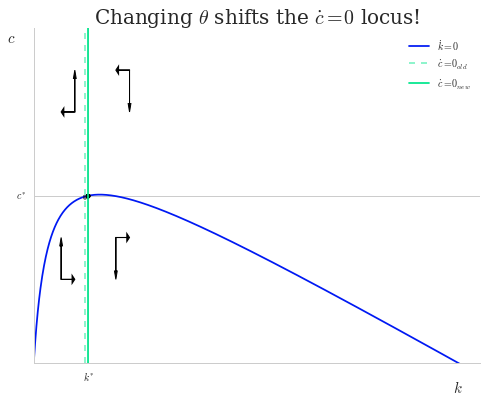

In [48]:
# my solution (100% increase in elasticity of substitution)
%run -i exercise_4a.py

#### part b)
A fall in the elasticity of substitution between capital and effective labor. 

In [ ]:
# INSERT CODE HERE!

In [ ]:
# my solution (10% fall)
%run -i exercise_4b.py

#### part c)
An increase in the depreciation rate of physical capital.

In [ ]:
# INSERT CODE HERE!

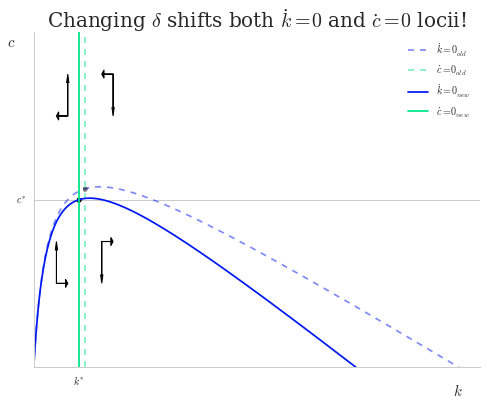

In [49]:
# my solution (50% increase)
%run -i exercise_4c.py

# Task 4: Simulating and solving the model  
Below is the familiar phase diagram for optimal growth model. Because the optimal growth model is saddle point stable (I will formally define saddle point stability in a minute) there exist two invariant manifolds: a stable manifold, $M_S$ and an unstable manifold, $M_U$.  These manifolds are called invariant because any path that begins on $M_S (M_U)$ will remain on $M_S (M_U)$. $M_S$ is called the stable manifold because any path that begins on the stable manifold will eventually converge to the steady state; $M_U$ is called the unstable manifold because any path the begins on $M_U$ will diverge away from the steady state. In order to solve the optimal growth model we need to compute its stable manifold, $M_S$.

<div align='center'> 
  <img src="graphics/ramsey-phase-diagram-with-manifolds.png" width="600" height="400" alt="Forward shooting"/>
</div>

**Note that what Romer calls the "saddle-path" is the same thing that I am calling the stable-manifold, $M_S$!**

## Simulating the optimal growth model
Before discussing the various methods for solving the optimal growth model it is necessary to first learn how to simulate trajectories (or time-paths) of the model. Just as we did in the previous lab on the Solow model, we will simulate trajectories for the optimal growth model using the `integrate` method. The following is a basic example of the syntax used to simulate a time path for the economy given any initial condition. 

    model.integrate(t0=0, y0=[k0, c0], h=1.0, T=10, integrator='lsoda', **kwargs)
    
The arguments are defined as follows: 

* `t0`: is the initial condition for the independent variable (which without loss of generality we can always set to zero for the optimal growth model); 
* `y0`: is an array-like container of initial conditions for the endogenous variables of the model (in this case we need to specify *both* $k_0$ and $c_0$; 
* `h`: is a floating point number that defines the step-size used by the numerical solver when approximating the time-path of the economy;
* `T`: is an integer representing the desired length of the time-path;
* `integrator`: is a valid finite-difference method for solving systems of ordinary differential equations.
* `**kwargs`: is an optional dictionary of keyword arguments that allow the user to directly tune the integrator as needed. Note that valid keyword arguments are integrator specific. 

In [ ]:
# always check the docstring!
model.integrate?

In [28]:
# initial conditions for c and k
c0 = model.steady_state.values['c_star'] / 4
k0 = model.steady_state.values['k_star'] / 4

# combine into a vector (ordering is important!)
init_vec = np.array([k0, c0])

# simulate a time path of the economy (column ordering is [t, k, c]!)
model.integrate(t0=0, y0=init_vec, h=1.0, T=10, integrator='lsoda')

array([[  0.        ,   0.85990884,   0.32915722],
       [  1.        ,   1.43203159,   0.48456343],
       [  2.        ,   2.04007289,   0.58662287],
       [  3.        ,   2.66520653,   0.64071362],
       [  4.        ,   3.30766613,   0.65927436],
       [  5.        ,   3.97142211,   0.65334903],
       [  6.        ,   4.65903455,   0.63136992],
       [  7.        ,   5.37058532,   0.59946238],
       [  8.        ,   6.10399294,   0.5619575 ],
       [  9.        ,   6.85567718,   0.52185073],
       [ 10.        ,   7.62119668,   0.48116648]])

We can plot a trajectory of the economy in phase space as follows...

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


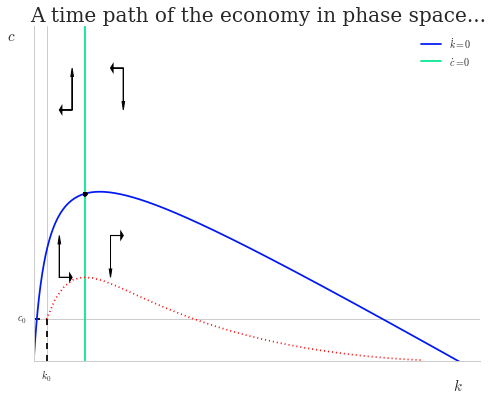

In [29]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=True)

# simulate the model
traj = model.integrate(t0=0, y0=init_vec, h=1.0, T=50, integrator='dopri5')

# plot the trajectory 
model.plot_trajectory(traj, color='r',ls=':')

# demarcate the initial condition
plt.vlines(k0, 0, c0, linestyle='dashed', color='k')
plt.xticks([k0], ['$k_0$'])
plt.hlines(c0, 0, k0, linestyle='dashed', color='k')
plt.yticks([c0], ['$c_0$'])

# change the plot title
plt.title('A time path of the economy in phase space...', fontsize=20, family='serif')
plt.show()

This is a case of very low initial consumption. Here both $\dot{c}$ and $\dot{k}$ are initially positive, but small. From the consumption Euler equation, $\dot{c}$ is directly proportional to $c$: when $c$ is small, $\dot{c}$ is also small. Therefore $c$ remains low and the economy evenually crosses the $\dot{c}=0$ locus. After crossing the $\dot{c}=0$ locus, $\dot{c}$ becomes negative while $\dot{k}$ remains positive. The economy moves down and to the right.

The code in the cell below fixes the initial condition for capital per effective worker and then plots trajectories for various initial conditions for consumption per effective worker...

//anaconda/lib/python2.7/site-packages/scipy/integrate/_ode.py:1213: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  'Unexpected istate=%s' % istate))


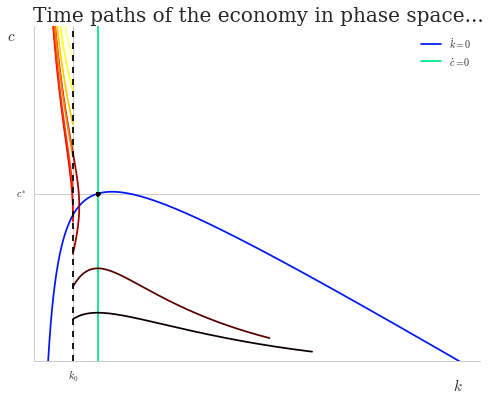

In [30]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=False)

# new initial condition for k
k0 = model.steady_state.values['k_star'] / 2

# set of initial conditions for c
N = 10
c_lower   = model.steady_state.values['c_star'] / 4
c_upper   = 2 * model.steady_state.values['c_star']
init_vals = np.linspace(c_lower, c_upper, N)

# color scheme
color_map = mpl.cm.hot(np.linspace(0, 1, N))

for i, c0 in enumerate(init_vals):
    
    # simulate the model
    traj = model.integrate(t0=0, y0=[k0, c0], h=0.1, T=20, integrator='lsoda')

    # plot the trajectory 
    model.plot_trajectory(traj, color=color_map[i])

# demarcate the initial condition
plt.axvline(k0, linestyle='dashed', color='k')
plt.xticks([k0], ['$k_0$'])

# change the plot title
plt.title('Time paths of the economy in phase space...', fontsize=20, family='serif')
plt.show()

We can easily repeat the above experiment for an initial condition for capital per effective worker which is greater than its steady state value...

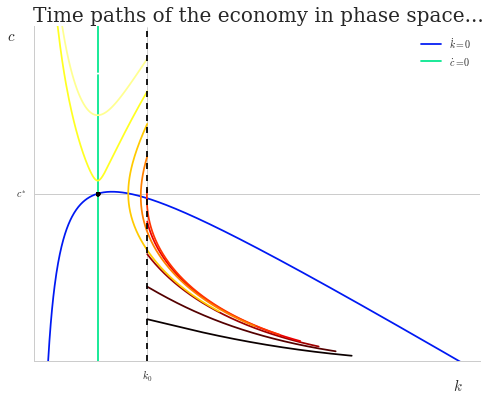

In [31]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=False)

# new initial condition for k
k0 = 2 * model.steady_state.values['k_star']

# set of initial conditions for c
N = 10
c_lower   = model.steady_state.values['c_star'] / 4
c_upper   = 2 * model.steady_state.values['c_star']
init_vals = np.linspace(c_lower, c_upper, N)

# color scheme
color_map = mpl.cm.hot(np.linspace(0, 1, N))

for i, c0 in enumerate(init_vals):
    
    # simulate the model
    traj = model.integrate(t0=0, y0=[k0, c0], h=0.1, T=20, integrator='lsoda')

    # plot the trajectory 
    model.plot_trajectory(traj, color=color_map[i])

# demarcate the initial condition
plt.axvline(k0, linestyle='dashed', color='k')
plt.xticks([k0], ['$k_0$'])

# change the plot title
plt.title('Time paths of the economy in phase space...', fontsize=20, family='serif')
plt.show()

### Exercise:

Play around with initial condition for consumption per effective worker, $c_0$, and see if you can find the a value for $c_0$ consistent with a trajectory that "hits" the steady at $T=50$. If you are successful, try increasing the length of the trajectory. Can you "hit" the steady state at $T=100$?

In [43]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=130, N=1000, arrows=False)

# you need to modify c0 and T to try and "hit" the steady state!
k0 = 4 * model.steady_state.values['k_star']
c0 = # INSERT YOUR CODE HERE!
T  = # INSERT YOUR CODE HERE!
traj = model.integrate(t0=0, y0=[k0, c0], h=0.1, T=T, integrator='dopri5')

# plot the trajectory 
model.plot_trajectory(traj, color='r')

# demarcate the initial condition
plt.vlines(k0, 0, c0, linestyle='dashed', color='k')
plt.xticks([k0], ['$k_0$'])
plt.hlines(c0, 0, k0, linestyle='dashed', color='k')
plt.yticks([c0], ['$c_0$'])

# change the plot title
plt.title('Can you hit the steady state?', fontsize=20, family='serif')
plt.show()

SyntaxError: invalid syntax (<ipython-input-43-faccd2d4df1a>, line 8)

## Solving the model via linearization
A frequently used qualitative technique for analyzing systems of non-linear differential equations is to draw inferences from linear approximations to the system. Such linear approximations are derived from the Taylor expansion of the system around an equilibrium point. If the model has multiple equilibria, each equilibrium requires a *separate* linear approximation. While linear (or higher order polynomial) approximations derived using a Taylor expansion can give the exact value of the function at the point of approximation, the approximation errors may grow rapidly as we move farther away from the point of expansion. Same ideas apply to a linear approximation of arbitrary non-linear system.  At the point of expansion (typically some steady-state equilibrium point of the system), the linear approximation pinpoints exactly the same equilibrium of the non-linear system. For a sufficiently small neighborhood of the equilibrium point, the behavior of the linear approximation should be roughly the same as the behavior of the non-linear system. 

To construct a linear approximation of the optimal growth model, begin by noting that time enters only indirectly into the analysis. Thus we can write

$$\dot{k}(t) = \dot{k}(k, c) \\ \dot{c}(t) = \dot{c}(k, c)$$  

We now wish to approximate this system of equations using a first-order Taylor expansion around the long-run equilibrium point $(k^*, c^*)$.

\begin{align}
\dot{k}(k, c) \approx& \dot{k}(k^*, c^*) + \frac{\partial \dot{k}}{\partial k}\bigg|_{k=k^*, c=c^*}(k - k^*) +  \frac{\partial \dot{k}}{\partial c}\bigg|_{k=k^*, c=c^*}(c - c^*)  \\
\dot{c}(k, c) \approx& \dot{c}(k^*, c^*) + \frac{\partial \dot{c}}{\partial k}\bigg|_{k=k^*, c=c^*}(k - k^*) +  \frac{\partial \dot{c}}{\partial c}\bigg|_{k=k^*, c=c^*}(c - c^*) 
\end{align}

Note that $\dot{k}(k^*, c^*) = \dot{c}(k^*, c^*) =0$, and define the following change of variables.

$$\tilde{k}(t) = k(t) - k^* \\ \tilde{c}(t) = c(t) - c^*$$ 

These definitions imply that  $\dot{\tilde{k}}(t) = \dot{k}(t)$ and $\dot{\tilde{c}}(t) = \dot{c}(t)$. Using this change of variables we can re-write the original non-linear system as follows.

\begin{align}
\begin{bmatrix}
	\dot{\tilde{k}}(t) \\  
	\dot{\tilde{c}}(t)
\end{bmatrix}
=&
\begin{bmatrix}
	\frac{\partial \dot{k}}{\partial k} & \frac{\partial \dot{k}}{\partial c} \\
	\frac{\partial \dot{c}}{\partial k} & \frac{\partial \dot{c}}{\partial c} \\
\end{bmatrix}
\Bigg|_{k=k^*, c=c^*}
\begin{bmatrix}
	\tilde{k}(t) \\
	\tilde{c}(t)
\end{bmatrix} \tag{4.2.1} \\
\tilde{k}(0) =& k_0 - k^* \tag{4.2.2}\\
\lim_{t\rightarrow\infty} |\tilde{c}(t)| =& 0 \tag{4.2.3}
\end{align}

where $\tilde{k}(t)$ is the pre-determined (i.e., state) variable and $\tilde{c}(t)$ is a free (i.e., control) variable. Note that we have transformed our original non-linear boundary value problem into a linear boundary value problem with constant coefficients which, assuming certain determinacy conditions are satisfied, can be solved explicitly.

The next step in the linearization is to compute the Jacobian matrix of partial derivatives and evaluate it at the long-run equilibrium. 

\begin{align}
\mathcal{J}\big|_{k=k^*, c=c^*}=& 
\begin{bmatrix}
	\frac{\partial \dot{k}}{\partial k} & \frac{\partial \dot{k}}{\partial c} \\
	\frac{\partial \dot{c}}{\partial k} & \frac{\partial \dot{c}}{\partial c} \\
\end{bmatrix}
\Bigg|_{k=k^*, c=c^*}
=
\begin{bmatrix}
	f'(k^*) - (n + g + \delta) & -1 \\
	\frac{c^*}{\theta}f''(k^*) & \frac{f'(k^*) - \delta - \rho - \theta g}{\theta} 
\end{bmatrix}
=
\begin{bmatrix}
	\beta & -1 \\
	\frac{c^*}{\theta}f''(k^*) & 0
\end{bmatrix}
\end{align}

where $\beta = f'(k^*) - (n + g + \delta)$. Substituting this result into 4.2.1 yields:

\begin{align}
\begin{bmatrix}
	\dot{\tilde{k}}(t) \\  
	\dot{\tilde{c}}(t)
\end{bmatrix}
=&
\mathcal{J}\big|_{k=k^*, c=c^*}
\begin{bmatrix}
	\tilde{k}(t) \\
	\tilde{c}(t)
\end{bmatrix} \tag{4.2.4} \\
\tilde{k}(0) =& k_0 - k^* \\
\lim_{t\rightarrow\infty} |\tilde{c}(t)| =& 0
\end{align}

Now we need to solve this system. To solve linear systems of differential equations with constant coefficients we need to diagonalize the matrix $\mathcal{J}$ by decomposing it into the product of two special matrices 

$$ P = \begin{bmatrix}P_{00} & P_{01} \\ P_{10} & P_{11} \\ \end{bmatrix},\ \Lambda=\begin{bmatrix}\lambda_{0} & 0 \\ 0 & \lambda_1 \\ \end{bmatrix} \tag{4.2.5}$$ 

such that 

\begin{equation}
\mathcal{J}\big|_{k=k^*, c=c^*} = P^{-1}\Lambda P \tag{4.2.6}
\end{equation} 

where the matrix $\Lambda$ is a diagonal matrix of whose entries are the eigenvalues of $\mathcal{J}$ and the rows of the matrix $P$ are the normalized left-eigenvectors of $\mathcal{J}$.  

In [32]:
# store the model's steady state values as a list
steady_state        = [model.steady_state.values['k_star'], model.steady_state.values['c_star']]

# evaluate the jacobian of the system at the models steady state 
evaluated_jacobian  = ramsey_jacobian(0, steady_state, model.params)

In [33]:
# display the result
print evaluated_jacobian

[[  3.37635544e-02  -1.00000000e+00]
 [ -6.79123556e-02  -2.08166817e-16]]


Computing eigenvalues and eigenvectors by hand is an incredibly tedious and error-prone process. Fortunately there exist a large number of high-quality algorithms for computing eigvalues and eigenvectors. We will use the `scipy.linalg.eig` routine. You can learn more about this routine by checking out the docstring...

In [34]:
# always read the docstring! 
linalg.eig?

Computing the eigenvalues and eigenvectors can be done as follows...

In [35]:
# linalg.eig returns a tuple of the form (values, vectors)
eig_vals, eig_vecs = linalg.eig(evaluated_jacobian, left=True, right=False)

In [36]:
# create the diagonal matrix Lambda using the eigenvalues
Lambda = np.diag(eig_vals)

# create the matrix P where rows are eigenvectors!
P      = eig_vecs.T

Confirm that the matrix diagonalization formula that I provided above is in fact correct...

In [37]:
# compute P^-1
P_inverse = linalg.inv(P)

# compare this result...
print P_inverse.dot(Lambda).dot(P)

[[  3.37635544e-02+0.j  -1.00000000e+00+0.j]
 [ -6.79123556e-02+0.j  -1.94289029e-16+0.j]]


In [41]:
# ...with this one!
print evaluated_jacobian

[[  3.50572188e-02  -1.00000000e+00]
 [ -6.01976933e-02   5.41233725e-16]]


Need to discuss determinacy issues.  In general, systems of linear equations can have zero, one, or an infinite number of solutions. We want 4.2.5 to have a unique solution. In order for the system to have a unique solution, we need...

1. Number of eigenvalues with *negative* real parts (i.e., stable eigenvalues) equals the number of pre-determined variables;
2. Number of eigenvalues with *positive* real parts (i.e., unstable eigenvalues) equals the number of free or control variables. 

The optimal growth model has one pre-determined variable (i.e., capital per effective worker) and one free or control variable (i.e., consumption per effective worker). Thus in order for the model to have a unique solution we need one eigenvalue with negative real part and one eigenvalue with positive real part.

Let's check the eigenvalues to make sure that we have a unique solution!

In [42]:
# mathematically speaking, the saddle path is unique!
eig_vals

array([ 0.26350614+0.j, -0.22844892+0.j])

Without loss of generality we can re-order the rows and columns of $P$ and $\Lambda$ so that the first row of $P$ corresponds to the stable eigenvector and $\lambda_0$ is the stable eigenvalue.

In [38]:
# swap rows of P 
P = P[::-1]

In [39]:
# note first row contains the stable eigenvector!
P

array([[ 0.23728809,  0.97143933],
       [ 0.26786767, -0.96345571]])

In [40]:
# swap rows and colums of Lambda
Lambda = Lambda[::-1, ::-1]

In [41]:
# now lambda_0 has negative real part
Lambda

array([[-0.24426445+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.27802800+0.j]])

Why can we swap rows and columns? [Elementary row/column operations](http://en.wikipedia.org/wiki/Elementary_row_operations#Operations) don't impact diagonalization procedure!

In [42]:
# compute P^-1
P_inverse = linalg.inv(P)

# still equals Jacobian!
print P_inverse.dot(Lambda).dot(P)

[[  3.37635544e-02+0.j  -1.00000000e+00+0.j]
 [ -6.79123556e-02+0.j  -1.94289029e-16+0.j]]


The whole point of diagonalizing the Jacobian is that doing so allows us to re-write equation 4.2.5 as follows.

\begin{align}
\begin{bmatrix}
	\dot{\tilde{k}}(t) \\  
	\dot{\tilde{c}}(t)
\end{bmatrix}
=&
P^{-1}\Lambda P
\begin{bmatrix}
	\tilde{k}(t) \\
	\tilde{c}(t)
\end{bmatrix} \tag{4.2.8}
\end{align}

Pre-multiplication by $P$ yields...

\begin{align}
\left(P
\begin{bmatrix}
	\dot{\tilde{k}}(t) \\  
	\dot{\tilde{c}}(t)
\end{bmatrix}\right)
=
\Lambda \left(P
\begin{bmatrix}
	\tilde{k}(t) \\
	\tilde{c}(t)
\end{bmatrix}\right) \tag{4.2.9}
\end{align}

Now we define *another* change of variables...

$$
\begin{bmatrix}
	\hat{k} \\  
	\hat{c}
\end{bmatrix}
=
P
\begin{bmatrix}
	\tilde{k} \\  
	\tilde{c}
\end{bmatrix} \tag{4.2.10}
$$

...in order to further reduce 4.2.5 to the following *separable* system of differential equations...

\begin{align}
\begin{bmatrix}
	\dot{\hat{k}}(t) \\  
	\dot{\hat{c}}(t)
\end{bmatrix}
=&
\Lambda
\begin{bmatrix}
	\hat{k}(t) \\
	\hat{c}(t)
\end{bmatrix} \tag{4.2.11}\\
\hat{k}(0) =& \hat{k}(0) \\
\lim_{t\rightarrow\infty} |\hat{c}(t)| =& 0 
\end{align}

Why is system described by 4.2.11 *separable*? The differential equation governing the evolution of $\hat{k}$ doesn't depend on the differential equation governing the evolution of $\hat{c}$! This means that each of the differential equations can be solved separately:

\begin{align}
    \hat{k}(t) =& \hat{k}(0)e^{\lambda_0 t} \tag{4.2.12} \\
    \hat{c}(t) =& \hat{c}(0)e^{\lambda_1 t} \tag{4.2.13} \\
\end{align}

where

\begin{align}
    \hat{k}(0) =& [P_{00}\tilde{k}(0) + P_{01}\tilde{c}(0)] \\
    \hat{c}(0) =& [P_{10}\tilde{k}(0) + P_{11}\tilde{c}(0)] \\
\end{align}

Now $\lambda_1 > 0$ implies that $\hat{c}(t)$ is exploding as $t\rightarrow \infty$! But recall that we need to satisfy  $\lim_{t\rightarrow\infty} |\hat{c}(t)|$. Solution is to choose $\tilde{c}(0)$ such that $\hat{c}(0)=0$ which forces $\hat{c}(t)=0$.

$$ P_{10}\tilde{k}(0) + P_{11}\tilde{c}(0) = 0 \implies \tilde{c}(0) = -\frac{P_{10}}{P_{11}}\tilde{k}(0) \implies \tilde{c}(t) = -\frac{P_{10}}{P_{11}}\tilde{k}(t) \tag{4.2.14} $$

Substituting our result for $\tilde{c}_0$ (and a bit of algebra!) allows us to recover the solution to 4.2.5.

\begin{align}
    \tilde{k}(t) =& \tilde{k}(0)e^{\lambda_0 t} \tag{4.2.15}\\
    \tilde{c}(t) =& -\frac{P_{10}}{P_{11}}\tilde{k}(t) \tag{4.2.16}\\
\end{align}

Finally, reversing our original change of variables yields the desired linear approximations of the functions $k(t)$ and $c(t)$ that solve the original system of differential equations.

\begin{align}
    k(t) =& k^* + (k(0) - k^*)e^{\lambda_0 t} \tag{4.2.17} \\
    c(t) =& c^* - \frac{P_{10}}{P_{11}}(k(t) - k^*) \tag{4.2.18} \\
\end{align}

Although linearization is really a *qualitative* technique for analyzing it is also the most widely used *quantitative*, numerical method in all of economics. Anyone interested in pursuing economic research (particularly macroeconomic research) should have a solid understanding of this linearization (in particular where it can go horribly wrong!)  

The syntax for computing a linear approximation of the saddle path/stable manifold is as follows:

    model.solve_linearization(k0=k0, ti=t)
    
You need to provide an initial condition for capital per effectiver worker, `k0`, as well as a grid of time points, `ti` at which you want to compute the solution.

In [43]:
# specify an initial condition and a set of time points
k0 = model.steady_state.values['k_star'] / 2
t  = np.linspace(0, 100, 10)

# generate a linearized approximation to the lower branch of the stable manifold
ms_lower_linear = model.solve_linearization(k0, t)

In [44]:
# display the linear approximation
print ms_lower_linear

[[   0.            1.71981768    0.83847142]
 [  11.11111111    3.32566662    1.28494239]
 [  22.22222222    3.43208288    1.31452909]
 [  33.33333333    3.43913487    1.31648974]
 [  44.44444444    3.43960219    1.31661967]
 [  55.55555556    3.43963316    1.31662828]
 [  66.66666667    3.43963521    1.31662885]
 [  77.77777778    3.43963534    1.31662889]
 [  88.88888889    3.43963535    1.31662889]
 [ 100.            3.43963535    1.31662889]]


In [45]:
model.plot_phase_diagram?

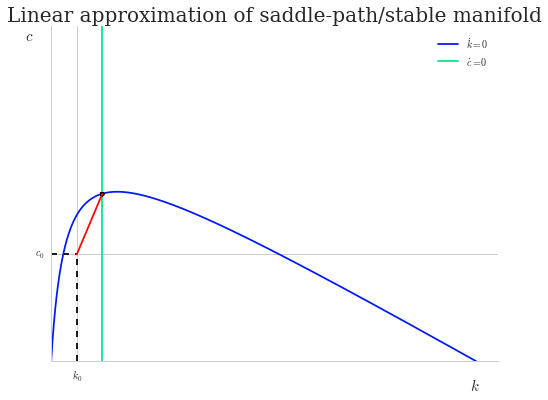

In [46]:
plt.figure(figsize=(8,6))

# plot a phase diagram
model.plot_phase_diagram(30)

# plot the lower half of the linearized stable manifold
model.plot_trajectory(ms_lower_linear, color='r')

# demarcate the initial condition
c0 = ms_lower_linear[0,2]
plt.vlines(k0, 0, c0, linestyle='dashed', color='k')
plt.xticks([k0], ['$k_0$'])
plt.hlines(c0, 0, k0, linestyle='dashed', color='k')
plt.yticks([c0], ['$c_0$'])

# change the title
plt.title('Linear approximation of saddle-path/stable manifold', fontsize=20, family='serif')
plt.show()

### Exercise:
Compute and plot a linear approximation to the upper branch of the saddle-path/stable manifold.

In [52]:
# specify an initial condition and a set of time points
k0 = # INSERT YOUR CODE HERE!
t  = # INSERT YOUR CODE HERE!

# generate a linearized approximation to the lower branch of the stable manifold
ms_upper_linear = # INSERT YOUR CODE HERE!

SyntaxError: invalid syntax (<ipython-input-52-5c3950e7009b>, line 2)

In [53]:
# specify an initial condition and a set of time points
k0 = 2 * model.steady_state.values['k_star']
t  = np.linspace(0, 100, 10)

# generate a linearized approximation to the lower branch of the stable manifold
ms_upper_linear = model.solve_linearization(k0, t)

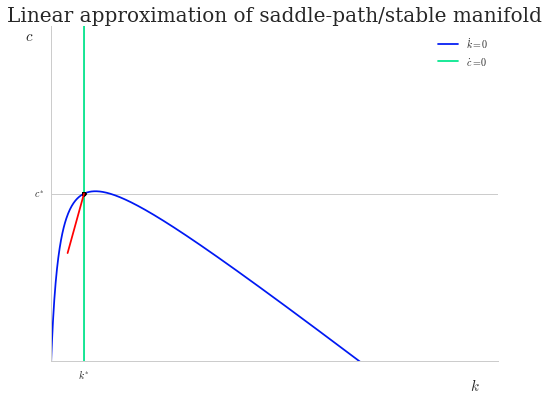

In [54]:
plt.figure(figsize=(8,6))

# plot a phase diagram
model.plot_phase_diagram(50)

# plot the lower half of the linearized stable manifold
model.plot_trajectory(ms_lower_linear, color='r')

# plot the lower half of the linearized stable manifold
# INSERT YOUR CODE HERE!

# change the title
plt.title('Linear approximation of saddle-path/stable manifold', fontsize=20, family='serif')
plt.show()

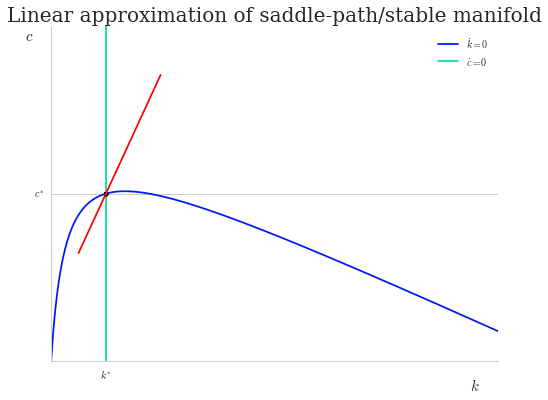

In [55]:
plt.figure(figsize=(8,6))

# plot a phase diagram
model.plot_phase_diagram(30)

# plot the lower half of the linearized stable manifold
model.plot_trajectory(ms_lower_linear, color='r')

# plot the lower half of the linearized stable manifold
model.plot_trajectory(ms_upper_linear, color='r')

# change the title
plt.title('Linear approximation of saddle-path/stable manifold', fontsize=20, family='serif')
plt.show()

## Solving the model via forward-shooting
In the previous section, you found a linear approximation to the stable manifold $M_S$ that was only valid in a neighborhood of the steady state.  In this task, we will see how to solve for the full non-linear stable manifold using a "forward shooting" approach. The forward shooting method for finding $M_S$ proceeds by guessing a feasible value for $c_0$ and then using some IVP scheme to generate the implied solution trajectories for the variables $k(t)$ and $c(t)$. If the initial choice of $c_0$ is too small, then the solution trajectory eventually crosses the $\dot{c}=0$ locus and $c(t)$ begins to fall.  Similarly, if the choice of $c_0$ is too large, then our path eventually crosses the $\dot{k}=0$ curve at which point $k(t)$ will start to fall. These observations motivate the forward shooting scheme described in pseudo-code below for an initial condition $k(0)=k_0 < k^*$

The pseudo-code below basically translates the above logic into something closer to an algorithm that we could implement in order to solve for an approximation of the stable manifold.

    # Bracket the true c(0) by setting cL=0 and cH = y + (1 - delta)k. 
    cL = 0
    cH = f(k0) + (1 - delta) * k0
    
    # Guess that c0 = 0.5(cH + cL) and specify a stopping tolerance, tol > 0.
    c0 = 0.5 * (cH + cL)
    
    while True:
        Solve the model as an IVP with k(0)=k0 and c(0)=c0
        if c is falling:
            # check for convergence
            if |c(T) - c^*| < tol:
                break
            # current guess too low!
            else:
                cL = c0 
                c0 = 0.5 * (c_H + c_L)
	
        elif k is falling:
            # check for convergence
            if |c(T) - c^*| < tol:
                break   
            # current guess too high!
            else: 
                cH = c0
                c0 = 0.5 * (cH + cL)

The figure below gives a sense of how the "forward shooting" algorithm converges to an initial condition, $c_0^*$, that yields a good approximation of the stable manifold, $M_S$.  

<div align='center'> 
  <img src="/graphics/ramsey-phase-diagram-with-trajs.png" alt="Forward shooting"/>
</div>

To solve the model using forward shooting we use the `solve_forward_shooting` method of the `Model` class. The basic syntax looks as follows:

    model.solve_forward_shooting(k0, h=1.0, tol=1e-6, mesg=True, integrator='dopri5', **kwargs)
    
where the arguments are an initial condition for capital per effective worker, `k0`; a step size, `h`, to use when solving the IVP for given initial conditions using some finite-difference method defined by `integrator`; a convergence tolerance, `tol`, defining how close to the steady state is close enough; a boolean flag, `mesg`, specifying whether or not you wish to print progress messages; and, `**kwargs` a dictionary of optional keyword arguments for the IVP solver.    

In [56]:
# check the docstring
model.solve_forward_shooting?

In [57]:
# set initial condition for capital per effective worker
k0 = model.steady_state.values['k_star'] / 2

# compute the lower branch of the stable manifold using forward shooting
ms_lower = model.solve_forward_shooting(k0, h=1.0, tol=1.5e-4, mesg=True, integrator='dopri5')

Old c0 too low, new c0 = 0.893935851972
Old c0 too high, new c0 = 0.74494654331
Old c0 too low, new c0 = 0.819441197641
Old c0 too high, new c0 = 0.782193870476
Old c0 too low, new c0 = 0.800817534058
Old c0 too low, new c0 = 0.81012936585
Old c0 too high, new c0 = 0.805473449954
Old c0 too high, new c0 = 0.803145492006
Old c0 too high, new c0 = 0.801981513032
Old c0 too high, new c0 = 0.801399523545
Old c0 too low, new c0 = 0.801690518289
Old c0 too high, new c0 = 0.801545020917
Old c0 too low, new c0 = 0.801617769603
Old c0 too high, new c0 = 0.80158139526
Old c0 too high, new c0 = 0.801563208089
Old c0 too high, new c0 = 0.801554114503
Old c0 too high, new c0 = 0.80154956771


We can plot the approximation of the stable manifold in phase space as follows...

NameError: name 'ms_lower' is not defined

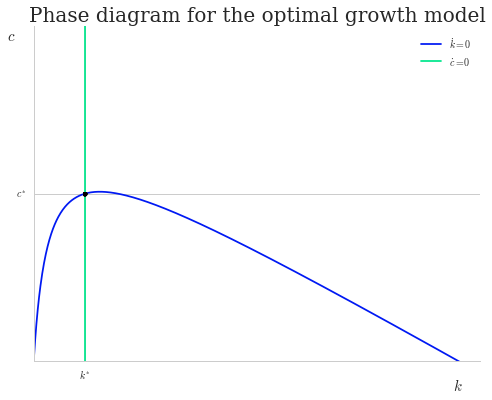

In [137]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=False)

# plot the trajectory 
model.plot_trajectory(ms_lower, color='r')

# demarcate the initial condition
c0 = ms_lower[0,2]
plt.vlines(k0, 0, c0, linestyle='dashed', color='k')
plt.xticks([k0], ['$k_0$'])
plt.hlines(c0, 0, k0, linestyle='dashed', color='k')
plt.yticks([c0], ['$c_0$'])

# change the plot title
plt.title('"Forward shooting" approximation of $M_S$', fontsize=20, family='serif')
plt.show()

### Exercise:

Compute and plot the upper half of the $M_S$ starting from an initial condition for capital per effective worker that is 2 times larger than the steady state value.

In [ ]:
# set initial condition for capital per effective worker
# INSERT YOUR CODE HERE!

# compute the upper branch of the stable manifold using forward shooting
# INSERT YOUR CODE HERE!

In [ ]:
plt.figure(figsize=(8,6))

# plot the phase diagram
# INSERT YOUR CODE HERE!

# plot the upper branch of the stable manifold
# INSERT YOUR CODE HERE!

# plot the lower branch of the stable manifold
model.plot_trajectory(ms_lower, color='r')

# change the plot title
plt.title('You have computed your first stable manifold!', fontsize=20, family='serif')
plt.show()

In [145]:
# set initial condition for capital per effective worker
k0 = 2 * model.steady_state.values['k_star']

# compute the upper branch of the stable manifold using forward shooting
ms_upper = model.solve_forward_shooting(k0, h=1.0, tol=1e-6, mesg=False, integrator='dopri5')

plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=False)

# plot the upper branch of the stable manifold
model.plot_trajectory(ms_upper, color='r')

# plot the lower branch of the stable manifold
model.plot_trajectory(ms_lower, color='r')

# change the plot title
plt.title('"Forward shooting" approximation of $M_S$', fontsize=20, family='serif')
plt.show()

KeyboardInterrupt: 

Quick graphical comparison of the linear approximation to the full, non-linear saddle path shows that the linear approximation is tangent to the non-linear approximation at the steady-state equilibrium point.

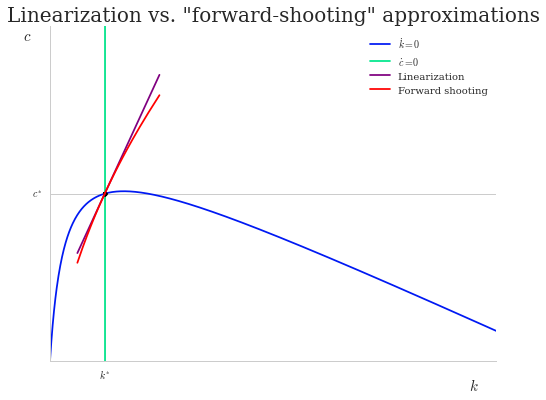

In [60]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=False)

# forward shooting approximation of stable manifold
model.plot_trajectory(ms_upper_linear, color='purple')
model.plot_trajectory(ms_lower_linear, color='purple', label='Linearization')

# forward shooting approximation of stable manifold
model.plot_trajectory(ms_upper, color='r')
model.plot_trajectory(ms_lower, color='r', label='Forward shooting')

# change the plot title
plt.title('Linearization vs. "forward-shooting" approximations', fontsize=20, family='serif')
plt.legend(loc=0, frameon=False, prop={'family':'serif'})
plt.show()

## Solving the model via reverse-shooting

The difficulty in applying forward shooting methods to continuous-time, infinite-horizon problems is that the terminal state is extremely sensitive to the initial guess. However, this observation also implies that the initial state corresponding to any given terminal state should be relatively *insensitive* to the terminal state.  Thus better strategy for solving continuous-time, infinite-horizon problems is to guess a value for the terminal state and integrate the system of differential equations backwards to find the correspondign initial condition. This method is known as "reverse shooting." 

The phase diagram suggests that using forward shooting to compute the stable manifold, $M_S$, of the model might be difficult for at least some parameter values and initial conditions $k(0)$.  Any initial deviation from $M_S$, however small, is magnified over time resulting in a path that increasingly departs from the exact solution. However, suppose that instead of computing the stable manifold, I wished instead to compute the unstable manifold, $M_U$.  As the figure below suggests, deviations from $M_U$, however large, become smaller over time.  

<div align='center' ><img src='graphics/deviations-from-MS-MU.png'></div>

In fact, all I would need to do in order to compute a path that lies on the unstable manifold is to choose a point "near" the steady state and then integrate the system forward.  

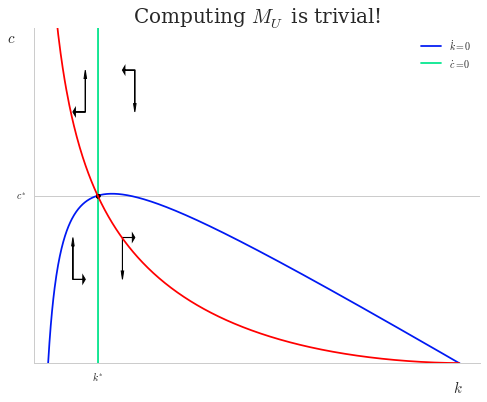

In [138]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=True)

# compute the unstable manifold
eps = 1e-5
k_star, c_star = model.steady_state.values['k_star'], model.steady_state.values['c_star']

mu_lower = model.integrate(t0=0, y0=[k_star + eps, c_star], h=0.1, T=300, integrator='dopri5')
mu_upper = model.integrate(t0=0, y0=[k_star, c_star + eps], h=0.1, T=300, integrator='dopri5')

# plot the unstable manifold
model.plot_trajectory(mu_upper, color='r')
model.plot_trajectory(mu_lower, color='r')

# change the plot title
plt.title('Computing $M_U$ is trivial!', fontsize=20, family='serif')
plt.show()

The "reverse shooting" approach transforms the system of equations in such a way so that the stable manifold of the original system becomes the unstable manifold of the transformed system and then solves for the unstable manifold by of the transformed system by shooting "backwards" from the steady state. 

Since time plays no direct role in the model, the household's choice of consumption per effective worker at time $t$ depends only on the value of capital per effective worker at time $t$. I  can express this by defining a policy function, $c(k)$, such that $c(k)=c(k(t))=c(t)$.  Furthermore, the original system of differential equations implies that the consumption policy function satisfies the following differential equation.

\begin{equation}
 	c'(k) = \frac{\dot{c}}{\dot{k}} = \left(\frac{c(k)}{\theta}\right)\left(\frac{f'(k) - \delta - \rho - \theta g}{f(k) - (n+g+\delta)k - c(k)}\right) \tag{4.1}
\end{equation}

Since optimality requires the economy to converge to its steady state, the solution $c(k)$ must satisfy the boundary condition $c(k^*)=c^*$. The reverse shooting approach solves for the lower portion of the consumption policy function by choosing some initial step-size $\epsilon > 0$, setting  

\begin{align}
k_0 =& k^*- \epsilon \notag \\
c_0 =& c(k^* - \epsilon) \approx c^* - \epsilon c'(k^*) \notag
\end{align}

and then integrating equation 4.1 *backward* using some IVP scheme.  To compute the upper portion of the policy function using reverse shooting, simply integrate equation 4.1 *forward* from the initial condition

\begin{align}
k_0 =& k^*+\epsilon \notag \\
c_0 =& c(k^* + \epsilon) \approx c^* + \epsilon c'(k^*)\notag.
\end{align} 

The following is an example of the basic syntax used to approximate the saddle-path/stable manifold using reverse shooting.

    model.solve_reverse_shooting(k0=k0, h=1.0, eps=1e-5, integrator='dopri5')
    

In [ ]:
# as always check the docstring!
model.solve_reverse_shooting?

In [49]:
# compute the upper branch of the stable manifold using reverse shooting
k0 = 2 * k_star
ms_upper_reverse = model.solve_reverse_shooting(k0=k0, h=1.0, eps=1e-5, integrator='dopri5')

In [50]:
# display the trajectory
print ms_upper_reverse

[[ 3.43964535  1.31663167]
 [ 4.43964535  1.5773963 ]
 [ 5.43964535  1.81064284]
 [ 6.43964535  2.02375414]
 [ 7.43964535  2.22148225]]


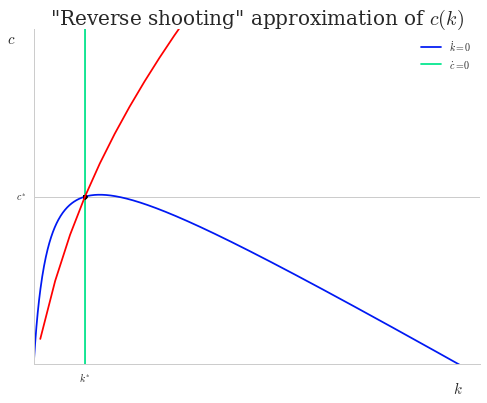

In [140]:
plt.figure(figsize=(8,6))

# plot the phase diagram
model.plot_phase_diagram(gridmax=30, N=1000, arrows=False)

# compute the stable manifold using reverse shooting
k0 = k_star / 4
ms_lower_reverse = model.solve_reverse_shooting(k0, h=1.0, eps=1e-5, integrator='dopri5')

k0 = 4 * k_star
ms_upper_reverse = model.solve_reverse_shooting(k0, h=1.0, eps=1e-5, integrator='dopri5')

# plot the stable manifold
plt.plot(ms_lower_reverse[:,0], ms_lower_reverse[:,1], color='r')
plt.plot(ms_upper_reverse[:,0], ms_upper_reverse[:,1], color='r')

# change the plot title
plt.title('"Reverse shooting" approximation of $c(k)$', fontsize=20, family='serif')
plt.show()

In [21]:
ramsey.calibrate_ces(model, iso3_code='GBR', bounds=[1950, 2011], sigma0=0.5, alpha0=0.5, theta0=2.5, rho=0.04)

Total sum of squares: 1372.10637276
Sucessful estimation of sigma and alpha: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
Calibration of theta successful! The solution converged.


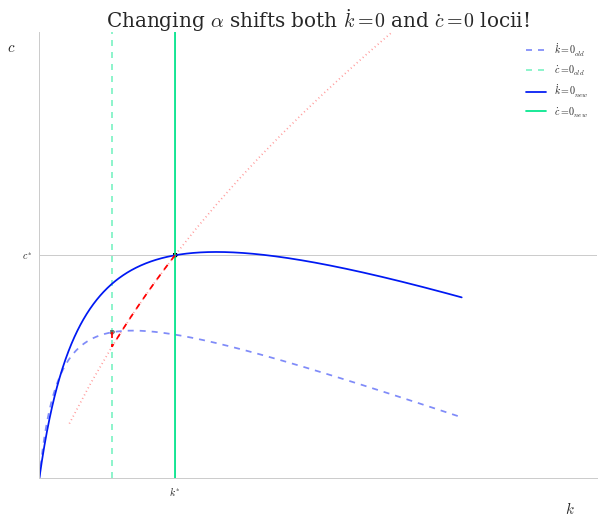

In [22]:
plt.figure(figsize=(10,8))
model.plot_phase_diagram(gridmax=20, N=1000, arrows=False, param='alpha', shock=1.4, reset=True, plot_traj=True, plot_manif=True)
plt.show()

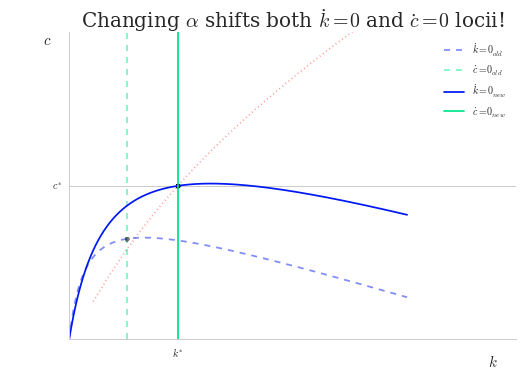

In [113]:
model.plot_phase_diagram(20, param='alpha',shock=1.4, plot_manif=True, return_traj=True )

plt.show()

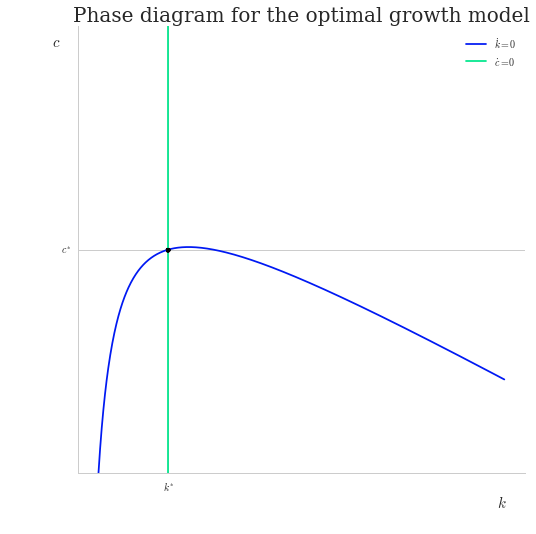

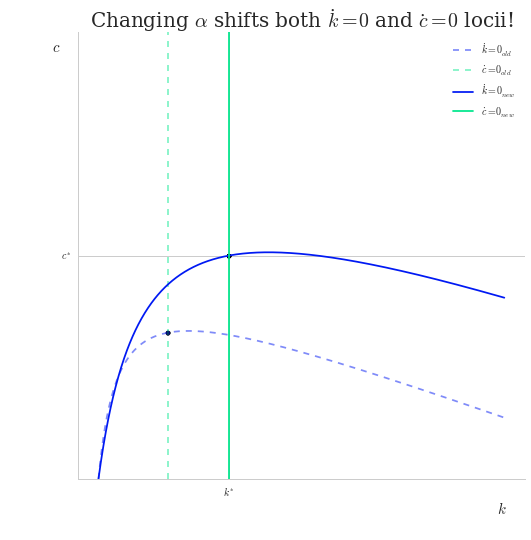

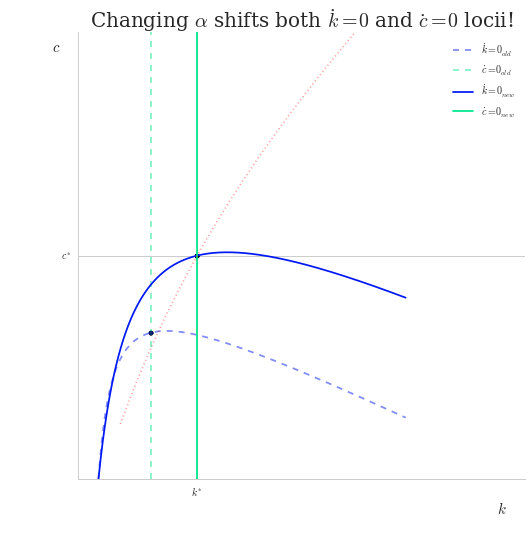

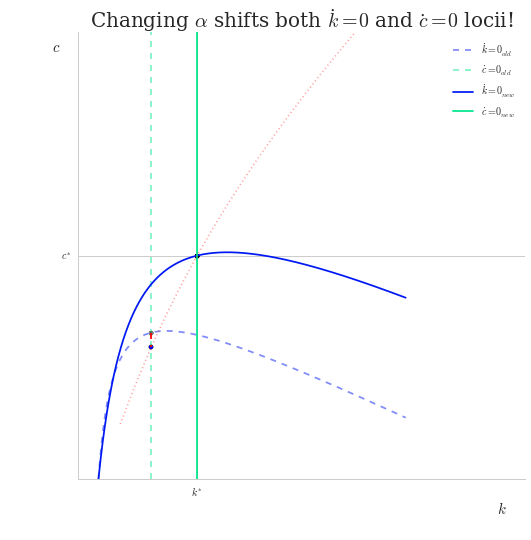

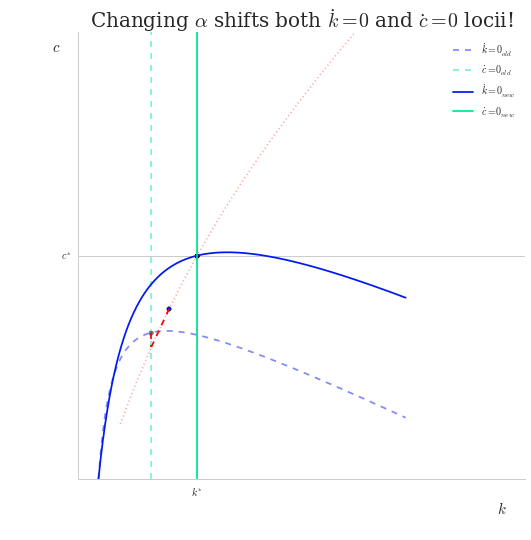

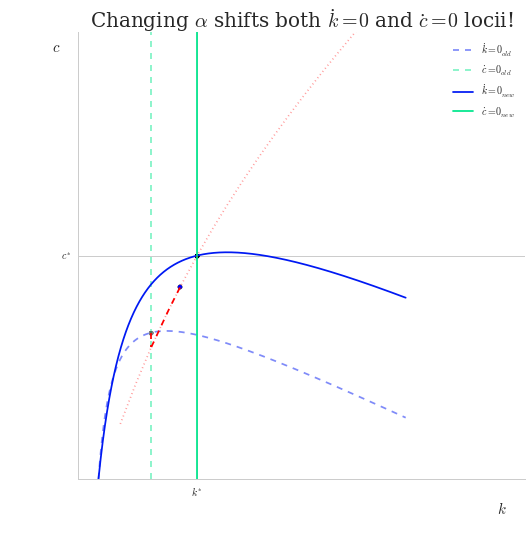

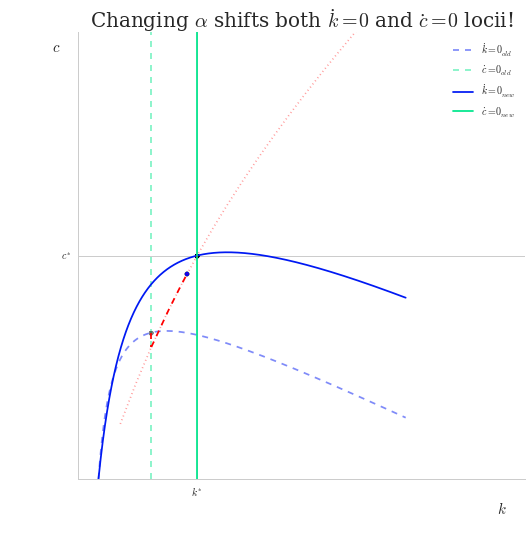

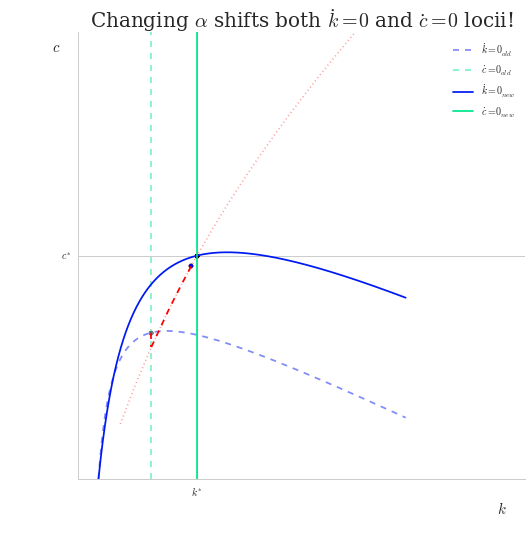

In [114]:
model.plot_movie(gridmax=20, pam='alpha', pamshock=1.4,t_step=25,formatt='mp4')

In [107]:
%%HTML
<video width="320" height="240" controls>
  <source src="pam_shock.mp4" type="video/mp4">
</video>

## Comparison: Speed vs. Accuracy

You have now seen three approaches to approximating the saddle-path/stable manifold of the optimal growth model: linearization, forward shooting, and reverse shooting. In this section, we compare the methods in terms of their relative speed and accuracy.

### Speed

In [99]:
# calibrate a model with Cobb-Douglas production using US data 
ramsey.calibrate_ces(model, iso3_code='USA', bounds=[1950, 2011], sigma0=1.0, rho=0.04)

Calibration of theta successful! The solution converged.


ramsey.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  model.data['atfpna'] = A**(1 / (1 - alpha)) * H


In [100]:
# define some initial condition for k
k_star = model.steady_state.values['k_star']

# define some bounds over which to approximate the consumption policy
kmin, kmax = k_star / 4, 4 * k_star

In [101]:
# time forward shooting algorithm (best of 3)
%timeit -n 1 -r 3 model.get_consumption_policy(kmin, kmax, method='forward_shooting', h=0.1, tol=1.5e-4)

1 loops, best of 3: 831 ms per loop


In [102]:
# time reverse shooting algorithm (best of 3)
%timeit -n 1 -r 3 model.get_consumption_policy(kmin, kmax, method='reverse_shooting', h=0.1, eps=1.5e-4)

1 loops, best of 3: 34.8 ms per loop


In [103]:
# time linearization algorithm (best of 3)
%timeit -n 1 -r 3 model.get_consumption_policy(method='linearization')

1 loops, best of 3: 5.74 ms per loop


The results illustrate a general tradeoff: linearization is typically much faster than reverse shooting, and reverse shooting is typically much faster than forward shooting. Linearization is fast because it is only computing a local approximation of the consumption policy function in a neighborhood of the steady state. Both the forward and reverse shooting methods, meanwhile, seek to globally approximate the consumption policy function over some interval. 

### Accuracy:

To assess the relative accuracy of our numerical methods we would ideally like to compare their approximations against an analytical benchmark.  Luckily for us it so happens that the optimal growth model with Cobb-Douglas production does have a few closed form solutions. 

The most general closed form solution requires that $\theta=\alpha$ and leads to a consumption policy function that is linear in $k$.

\begin{align}
	k(t)=& \left[k_0^{1-\alpha}e^{-(1-\alpha)\left(\frac{\delta + \rho + \alpha g}{\alpha}\right) t} +  \left(\frac{\alpha}{\delta + \rho + \alpha g}\right)\left(1 - e^{-(1-\alpha)\left(\frac{\delta + \rho + \alpha g}{\alpha}\right) t}\right)\right]^{\frac{1}{1-\alpha}} \tag{??}\\
	c(t) =& \left(\frac{(1 - \alpha) \delta + \rho - \alpha n}{\alpha}\right)k(t) \tag{??}
\end{align}

Here are some Python functions encoding this analytic solution...

In [104]:
def analytic_capital_1(k0, t, params):
    """
    Computes the analytic solution for the time path of capital (per person/
    effective person) in an optimal growth model with Cobb-Douglas production technology 
    technology where the inverse elasticity of intertemporal substitution equals capital's 
    share, alpha.
    
    Arguments:
        
        k0:     (float) Initial value for capital (per person/effective person) 
        
        t:      (array-like) (T,) array of points at which the solution is 
                desired.
        
        params: (dict) Dictionary of model parameters.
            
    Returns:
            
        analytic_k: (array-like) (T,) array representing the time path of 
                    capital (per person/effective person).

    """
    # extract parameter values
    g     = params['g']
    n     = params['n']
    alpha = params['alpha']
    delta = params['delta']
    rho   = params['rho']
        
    # lambda governs the speed of convergence
    lmbda = ((delta + rho + alpha * g) / alpha) * (1 - alpha)
        
    # analytic solution for k at time t
    k_t   = (((alpha / (delta + rho + alpha * g)) * (1 - np.exp(-lmbda * t)) + 
              k0**(1 - alpha) * np.exp(-lmbda * t))**(1 / (1 - alpha)))
            
    return k_t

def analytic_consumption_1(k0, t, params):
    """
    Computes the analytic solution for the time path of consumption (per person/
    effective person) in a optimal growth model with Cobb-Douglas production technology 
    technology where the inverse elasticity of intertemporal substitution equals capital's 
    share, alpha.
    
    Arguments:
        
        k0:     (float) Initial value for capital (per person/effective person)     
        
        t:      (array-like) (T,) array of points at which the solution is 
                desired.
                
        params: (dict) Dictionary of model parameter values.
            
    Returns:
            
        analytic_c: (array-like) (T,) array representing the time path of 
                    consumption (per person/effective person).

    """
    # extract parameter values
    g     = params['g']
    n     = params['n']
    alpha = params['alpha']
    delta = params['delta']
    rho   = params['rho']
        
    # analytic solution consumption at time t
    c_t = ((((1 - alpha) * delta + rho - alpha * n) / alpha) * 
           ramsey_analytic_capital(k0, t, params))
            
    return c_t

def analytic_solution_1(k0, t, params):
    """
    Computes the analytic solution for an optimal growth model with Cobb-Douglas 
    production technology technology where the inverse elasticity of intertemporal 
    substitution equals capital's share, alpha.
    
    Arguments:
        
        k0:     (float) Initial value for capital (per person/effective person)     
        
        t:      (array-like) (T,) array of points at which the solution is 
                desired.
        
        params: (dict) Dictionary of model parameters.
            
    Returns:
            
        analytic_traj: (array-like) (T,2) array representing the analytic 
                       solution trajectory.

    """
    # analytic solution for capital at time t
    k_t = analytic_capital_1(k0, t, params) 
        
    # analytic solution for consumption at time t
    c_t = analytic_consumption_1(k0, t, params)

    # combine into a (T, 2) array
    tup = (t[:,np.newaxis], k_t[:,np.newaxis], c_t[:,np.newaxis])
    analytic_traj = np.hstack(tup)
    
    return analytic_traj

In [105]:
def analytic_consumption_policy_1(k):
    """
    Computes the analytic solution for the consumption (per person/
    effective person) policy function in a Ramsey model with Cobb-Douglas 
    production technology where the coefficient of relative risk aversion, 
    theta, equals capital's share, alpha.
    
    Arguments:
        
        k:      (array-like) Array of values for capital (per person/
                effective person)     
            
    Returns:
            
        c_policy: (array-like) (T,) array representing the consumption 
                  (per person/effective person) policy function.

    """
    # extract parameter values
    g     = model.params['g']
    n     = model.params['n']
    alpha = model.params['alpha']
    delta = model.params['delta']
    rho   = model.params['rho']
        
    # analytic solution consumption at time t
    c_policy = (((1 - alpha) * delta + rho - alpha * n) / alpha) * k
            
    return c_policy

In [106]:
analytic_params_1 = {'A0':1.0, 'rho':0.04, 'g':0.025, 'theta':0.33, 'L0':1.0, 
                   'alpha':0.33, 'delta':0.1, 'sigma':1.0, 'n':0.025}

In [107]:
# update the model parameters
model.update_model_parameters(analytic_params_1)

# re-compute the steady state values
model.steady_state.set_values()

# extract steady state value
k_star = model.steady_state.values['k_star']
kmin, kmax = 0.5 * k_star, 2.0 * k_star

Compute approximations of the consumption policy function using linearization, forward shooting, and reverse shooting...

In [108]:
# approximate consumption policy function using linearization
linearized_policy = model.get_consumption_policy(method='linearization')

# approximate consumption policy function using forward shooting
forward_shooting_policy = model.get_consumption_policy(kmin, kmax, method='forward_shooting', deg=3)

# approximate the consumption policy function using reverse shooting
reverse_shooting_policy = model.get_consumption_policy(kmin, kmax, method='reverse_shooting', deg=3)

...and compare then to the analytic consumption policy function using the $L^2$ metric (i.e., sum of point-wise squared deviations).

In [109]:
# grid of points at which to compare methods
kgrid = np.linspace(kmin, kmax, 1000)

# linearization is accurate when consumption policy is linear
model.compare_policies(analytic_consumption_policy_1, linearized_policy, kgrid, metric='L2')

4.65480319375e-28

In [110]:
# forward shooting looks pretty good
model.compare_policies(analytic_consumption_policy_1, forward_shooting_policy, kgrid, metric='L2')

6.50715126874e-13

In [111]:
# reverse shooting also does extremely well
model.compare_policies(analytic_consumption_policy_1, reverse_shooting_policy, kgrid)

3.32637375531e-28

A linear consumption policy function is not a terribly useful benchmark for differentiating our numerical methods. In order to obtain a closed-form solution of the model that is sufficiently non-linear, I focus on the a special case of the model with a constant gross savings rate. Note that a constant gross savings rate implies that the representative household is saving a constant fraction of its income at each point in time.  In order for it to be optimal for the representative household to have a constant gross savings rate, the discount rate must satisfy the following rather peculiar restriction.

$$ \rho = \alpha\theta(n + g + \delta) - (\delta + \theta g) > 0$$

Assuming that the above parameter restriction is satisfied, one can obtain the following closed form solution for the functions $k(t)$ and $c(t)$.

\begin{align}
k(t)=& \left[k_0^{1-\alpha}e^{-\lambda t} +  \left(\frac{1}{\theta(n+g+\delta)}\right)\left(1 - e^{-\lambda t}\right)\right]^{\frac{1}{1-\alpha}} \\
c(t) =& \left(\frac{\theta - 1}{\theta}\right)k(t)^{\alpha}
\end{align}

In [112]:
def analytic_capital_2(k0, t, params):
    """
    Computes the analytic solution for the time path of capital (per person/
    effective person) in a Ramsey model with Cobb-Douglas production technology 
    with a constant gross savings rate.
    
    Arguments:
        
        k0:     (float) Initial value for capital (per person/effective person)     
        t:      (array-like) (T,) array of points at which the solution is 
                desired.
        params: (dict) Dictionary of model parameters.
            
    Returns:
            
        analytic_k: (array-like) (T,) array representing the time path of 
                    capital (per person/effective person).

    """
    # extract parameter values
    g     = params['g']
    n     = params['n']
    alpha = params['alpha']
    delta = params['delta']
    theta = params['theta']
        
    # lambda governs the speed of convergence
    lmbda = (1 - alpha) * (n + g + delta)
        
    # analytic solution for k at time t
    k_t   = (((1 / (theta * (n + g + delta))) * (1 - np.exp(-lmbda * t)) + 
              k0**(1 - alpha) * np.exp(-lmbda * t))**(1 / (1 - alpha)))
            
    return k_t

def analytic_consumption_2(k0, t, params):
    """
    Computes the analytic solution for the time path of consumption (per person/
    effective person) in a Ramsey model with Cobb-Douglas production technology 
    with a constant gross savings rate.
    
    Arguments:
        
        k0:     (float) Initial value for capital (per person/effective person)     
        t:      (array-like) (T,) array of points at which the solution is 
                desired.
        params: (dict) Dictionary of model parameter values.
            
    Returns:
            
        analytic_c: (array-like) (T,) array representing the time path of 
                    consumption (per person/effective person).

    """
    # extract parameter values
    alpha = params['alpha']
    theta = params['theta']
        
    # analytic solution consumption at time t
    c_t = ((theta - 1) / theta) * ramsey_analytic_capital(k0, t, params)**alpha
            
    return c_t

def analytic_solution_2(k0, t, params):
    """
    Computes the analytic solution for the Ramsey model with Cobb-Douglas
    production technology and a constant gross savings rate.
    
    Arguments:
        
        k0:     (float) Initial value for capital (per person/effective person)     
        t:      (array-like) (T,) array of points at which the solution is 
                desired.
        params: (dict) Dictionary of model parameters.
            
    Returns:
            
        analytic_traj: (array-like) (T,2) array representing the analytic 
                       solution trajectory.

    """
    # analytic solution for capital at time t
    k_t = ramsey_analytic_capital(k0, t, params) 
        
    # analytic solution for consumption at time t
    c_t = ramsey_analytic_consumption(k0, t, params)

    # combine into a (T, 2) array
    tup = (t[:,np.newaxis], k_t[:,np.newaxis], c_t[:,np.newaxis])
    analytic_traj = np.hstack(tup)
    
    return analytic_traj

In [113]:
def analytic_consumption_policy_2(k):
    """
    Computes the analytic solution for the consumption (per person/
    effective person) policy function in a Ramsey model with Cobb-Douglas 
    production technology and a constant gross savings rate.
    
    Arguments:
        
        k:      (array-like) Array of values for capital (per person/
                effective person)     
        params: (dict) Dictionary of model parameter values.
            
    Returns:
            
        c_policy: (array-like) (T,) array representing the consumption 
                  (per person/effective person) policy function.

    """
    # extract parameter values
    alpha = model.params['alpha']
    theta = model.params['theta']
        
    # analytic solution consumption at time t
    c_policy = ((theta - 1) / theta) * k**alpha
            
    return c_policy

In [114]:
def get_rho(params):
    """
    Computes the required discount rate in order to insure that 
    optimal consumption policy is consistent with the assumption of
    a constant gross savings rate.
    
    """
    # extract parameter values
    g     = params['g']
    n     = params['n']
    alpha = params['alpha']
    delta = params['delta']
    theta = params['theta']
    
    rho = alpha * theta * (n + g + delta) - (delta + theta * g)
    params['rho'] = rho

In [115]:
# new set of baseline params...note rho is missing!
analytic_params_2 = {'A0':1.0, 'g':0.02, 'theta':2.5, 'L0':1.0, 
                     'alpha':0.5, 'delta':0.04, 'sigma':1.0, 'n':0.025}

# compute rho based on the other params
get_rho(analytic_params_2)

In [116]:
# checkout the required discount factor...peculiar restriction doesn't seem that crazy!
analytic_params_2

{'A0': 1.0,
 'L0': 1.0,
 'alpha': 0.5,
 'delta': 0.04,
 'g': 0.02,
 'n': 0.025,
 'rho': 0.016249999999999987,
 'sigma': 1.0,
 'theta': 2.5}

In [117]:
# update the model parameters
model.update_model_parameters(analytic_params_2)

# re-compute the steady state values
model.steady_state.set_values()

# extract steady state value
k_star = model.steady_state.values['k_star']

kmin, kmax = 0.5 * k_star, 2.0 * k_star
kgrid = np.linspace(kmin, kmax, 1000)

In [118]:
# approximate consumption policy function using linearization
linearized_policy = model.get_consumption_policy(method='linearization')

# approximate consumption policy function using forward shooting
forward_shooting_policy = model.get_consumption_policy(kmin, kmax, method='forward_shooting', deg=3)

# approximate the consumption policy function using reverse shooting
reverse_shooting_policy = model.get_consumption_policy(kmin, kmax, method='reverse_shooting', deg=3)

Results? Linearization is pretty terrible *relative* to...

In [119]:
model.compare_policies(analytic_consumption_policy_2, linearized_policy, kgrid, metric='L2')

9.61068186425

...forward shooting which is roughly 11 orders of magnitude more accurate!

In [120]:
model.compare_policies(analytic_consumption_policy_2, forward_shooting_policy, kgrid, metric='L2')

3.08972562148e-10

Finally, reverse shooting is roughly 100 times more accurate than linearization and slightly more accurate that forward shooting.

In [121]:
model.compare_policies(analytic_consumption_policy_2, reverse_shooting_policy, kgrid, metric='L2')

2.3906685627e-11

These results generalize: 

1. Unless the interval you are interested in is *very* small, then shooting methods will be signficantly more accurate (if somewhat slower) than linearization. 
2. Reverse shooting is typically faster and more accurate than forward shooting and thus is the generally preferable approach.

## Task 5: Impulse response functions

Suppose that we start the optimal growth model economy in steady-state with current parameter values and then at $t=2013$ shock the economy by doubling the discount rate. How should we expect the time-paths of capital, output, and consumption per effective worker to respond? How about the time paths of the return to capital and the real wage?

We can assess the short-run comparative statics of the optimal growth model by plotting [impulse response functions (IRFs)](http://en.wikipedia.org/wiki/Impulse_response).  The `plot_impulse_response` method of the `ramsey.Model` class can be used to plot three different types of impulse response functions (i.e., ``efficiency_units``, ``per_capita``, or ``levels``) following a multiplicative shock to any of the models exogenous parameters. 

The syntax for plotting the IRFs (computed using forward shooting) for capital per effective worker, consumption per effective worker, and the real return to capital in response to a doubling of the discount rate would look as follows.

    model.plot_impulse_response(variables=['k', 'c', 'r'], method='forward_shooting', kind='efficiency_units',
                                param='rho', shock=1.0, T=50, log=False, figsize=(10,6))
                            

In [ ]:
# check the docstring!
model.plot_impulse_response?

In [122]:
# calibrate the model to the UK 
ramsey.calibrate_ces(model, iso3_code='GBR', bounds=[1950, 2011], 
                     sigma0=0.5, alpha0=0.5, theta0=2.5, rho=0.04)

Total sum of squares: 1372.10637276
Sucessful estimation of sigma and alpha: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
Calibration of theta successful! The solution converged.


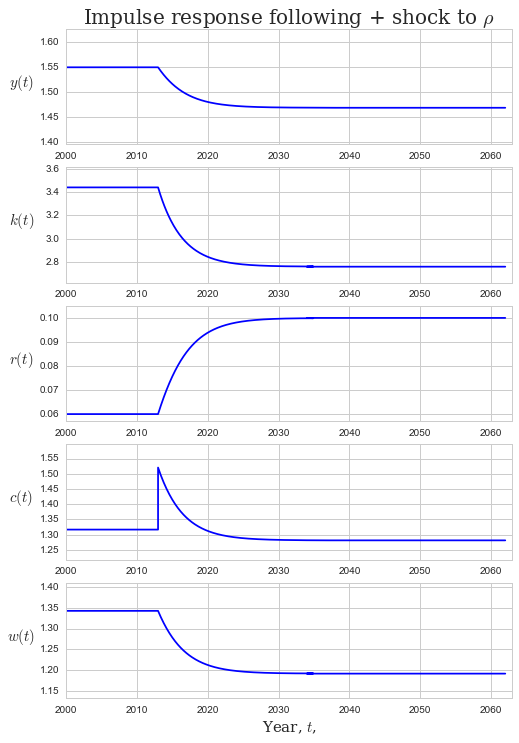

In [123]:
# can also plot irfs for all variables at once!
model.plot_impulse_response(variables='all', method='forward_shooting', kind='efficiency_units',
                            param='rho', shock=2.0, T=50, figsize=(8,12), log=False)
plt.show()

At the time of the change in $\rho$, the value of $k$ (i.e., the stock of capital per effective worker) is predetermined and thus cannot change discontinuously. By contrast consumption per effective worker, $c$, is free to jump at the time of the shock. In the instant following the change in $\rho$ the representative household increases its consumption. Why? The increase in $\rho$ means that they are now discounting future utility from consumption more heavily which means that the value of current consumption has increased (relative to future consumption).

### Exercise 5

This exercise asks you to consider the impact of a productivity growth slowdown on savings. Consider a Ramsey-Cass-Koopmans economy that is on its balanced growth path, and suppose that there is a permanent fall in the rate of technological growth, $g$.

#### Part a)
Making use of the `plot_phase_diagram` method show how, if at all, does the fall in $g$ affect the $\dot{k}=0$ and $\dot{c}=0$ curves?

In [ ]:
# INSERT YOUR CODE HERE!

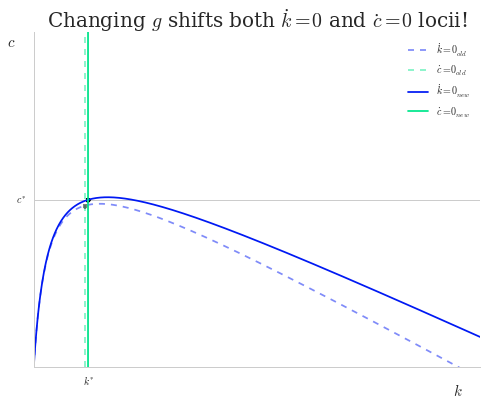

In [126]:
# my solution
%run -i exercise_5a.py

#### Part b)

What happens to consumption per effective worker, $c$, at the time of the change?

In [ ]:
# INSERT YOUR CODE HERE!

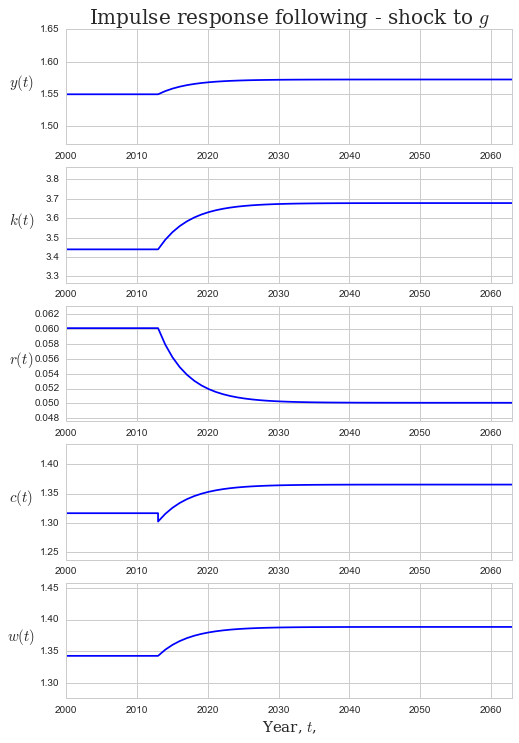

In [125]:
# my solution 
%run -i exercise_5b.py